# Getting started with acoustic well log data using the dlisio Python library on the Volve Data Village dataset

### Erlend Magnus Viggen<sup>1</sup>, Erlend Hårstad<sup>2</sup>, Jørgen Kvalsvik<sup>2</sup>

<sup>1</sup> Centre for Innovative Ultrasound Solutions and Dept. of Circulation and Medical Imaging, Norwegian University of Science and Technology, Trondheim, Norway
<br/>
<sup>2</sup> Software Innovation Bergen, Equinor ASA, Bergen, Norway

## Introduction

This Jupyter Notebook is a companion to the [article](https://www.researchgate.net/publication/340645995_Getting_started_with_acoustic_well_log_data_using_the_dlisio_Python_library_on_the_Volve_Data_Village_dataset) of the same name, published in the Proceedings of the 43rd Scandinavian Symposium on Physical Acoustics in 2020. While the article provides more background information and a tidier presentation of the results, this notebook shows the code underlying these results.

The notebook uses the dlisio library to investigate data from a sonic and an ultrasonic tool in an integrity well log file from the open [Volve Data Village dataset](https://data.equinor.com/dataset/Volve). The file in question is `WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS`, from well F-11 B. While investigating acoustic data from two specific tools is the main topic of this notebook, other types of data can be similarly investigated using dlisio.

This notebook is published under an [MIT license](https://github.com/equinor/dlisio-notebooks/blob/master/LICENSE) and the newest version was developed using `python 3.10.14`. All packages used in this notebook and their versions are listed in `requirements.txt` in the root folder of this repository. Run `pip install -r requirements.txt` if you wish to install all the correct versions. The newest version of this notebook can always be found [on github](https://github.com/equinor/dlisio-notebooks/blob/master/acoustic.ipynb).

***Privacy note:*** *This notebook hides well log parameters that contain people's names. This is to avoid their names being tied to the log file by search engines without their explicit consent. Users of the notebook are of course free to uncomment the code lines that hide these names.*

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import dlisio
from dlisio import dlis
import pandas as pd
import numpy as np
import scipy.signal as signal
import logging
import copy

# Ensure that we can see pandas tables of up to 500 rows
pd.set_option('display.max_rows', 500)

# Set a default DPI for all figures in this file. Lower DPI gives smaller figures, higher bigger.
mpl.rcParams['figure.dpi'] = 100

## Fetch the file


The Volve data is made publically available by Equinor through Azure BlobStore. In the next cell we download the dlis file that we intend to work with in this notebook from that BlobStore. In order to do that, we first need to head over to https://data.equinor.com/dataset/Volve to fetch a sas token (our credentials). After logging in with a Microsoft account and accepting the terms and conditions, scroll to the bottom of the page and copy the sas token from the shared access signature URI. Note that the sas token is only the last part of that URI, i.e. everything _after_ the question mark (excluding the question mark itself). Paste it into the `sas` variable in the cell below and run it.

In [2]:
from os import path
from azure.storage.blob import BlobClient

dst = 'WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS'
url = 'https://datavillagesa.blob.core.windows.net/volve/Well_logs_pr_WELL/15_9-F-11 B/11. INTEGRITY LOGS/RAW/WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS'
sas = 'PASTE YOUR SAS TOKEN HERE!'

if not path.isfile(dst):
    client = BlobClient.from_blob_url(url, credential = sas)
    stream = client.download_blob()
    
    with open(dst, "wb") as f:    
        f.write(stream.readall())

# Load the file

### Set encodings for dlisio

By default a `.DLIS`-file should only contain strings that can be decoded with 'utf-8', which is the default encoding in Python. However, a lot of files use different encodings for strings. These need special care. Sadly, there is no way for dlisio to guess which encoding to use, simply because multiple encodings might work but yield different results. However, dlisio can be told to use whatever encoding you believe is used in the file with the [set_encodings](https://dlisio.readthedocs.io/en/latest/common-api.html#dlisio.common.set_encodings) function.

For the file that we are investigating in this notebook, we need to use the `latin1` encoding. 

In [3]:
dlisio.common.set_encodings(['latin1'])

### Logical files

Before starting to work with DLIS and dlisio, there are a couple of concepts you should be familiar with. Firstly, a DLIS-file _may_ contain multiple logical files. In short, this means that there might be multiple files within a  `.DLIS` disk file. In practice, logical files are independent of each other and you can regard them as such. The [dlisio documentation](https://dlisio.readthedocs.io/en/latest/dlis/userguide.html) explains the definition of a logical file in more detail. 

Because of this, the syntax for opening a DLIS file with dlisio can look a bit strange at a first glance. The syntax we use in the cell below extracts the _first_ logical file into `f` and puts the remaining logical files into `f_tail`. dlisio's documentation offers more in-detail [examples](https://dlisio.readthedocs.io/en/latest/dlis/userguide.html) of loading files.

In [4]:
filename = 'WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS'

f, *f_tail = dlis.load(filename)

if len(f_tail): logging.warning('There are more logical files in tail')

### Origins

Secondly, within a logical file there are one or more [Origin](https://dlisio.readthedocs.io/en/stable/dlisio.html#origin) objects. These describe the origin of the file, and contain information about which field and well the data is from. The fact that there might be _multiple_ origins opens up the possiblity of the logical file containing information from _multiple_ wells. In that case, the origin must be checked for every piece of information in the logical file to avoid misinterpretation of the information.

Luckily the more common case is that a `.DLIS`-file contains _one_ logical file, with _one_ origin. When this is true, we can safely assume that all the information stems from the same well.

In [5]:
origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

# Get an overview of the file

All dlisio objects have a `describe()` function that returns a string containing useful overview information about that object. Describing the file gives an overview of how many frames and channels it contains, and which DLIS sets it contains.

In [6]:
f.describe()

------------
Logical File
------------
Description : LogicalFile(MaxWell_13Dlis)
Frames      : 3
Channels    : 310

Known objects
--
PROCESS                 : 15
CALIBRATION-MEASUREMENT : 7
ORIGIN                  : 1
FILE-HEADER             : 1
CALIBRATION-COEFFICIENT : 19
FRAME                   : 3
TOOL                    : 7
PARAMETER               : 473
EQUIPMENT               : 27
CALIBRATION             : 9
CHANNEL                 : 310
AXIS                    : 2

Unknown objects
--
440-HZVERSIONINFO           : 1
440-LIS-INPU                : 307
440-CALIBRATION-COEFFICIENT : 19
440-OP-TOOL                 : 7
440-PASS                    : 1
440-FILE                    : 1
440-CHANNEL                 : 307


We can also run `describe()` on the `origin` object for some overall information about the data:

In [7]:
origin.describe()

------
Origin
------
name   : LAP-87FCBFDC-5AE1-4C07-9822-C5A250FDCFE9
origin : 57
copy   : 0

Logical file ID          : MaxWell_13Dlis
File set name and number : USIT / 1056964608
File number and type     : 1 / CUSTOMER

Field                   : Volve
Well (id/name)          : 15/9-F-11 / 15/9-F-11 B
Produced by (code/name) : 440 / Schlumberger
Produced for            : Statoil
Order number            : USIT 9_58
Run number              : 1
Descent number          : 0
Created                 : 2013-06-06 23:22:34.906000

Created by              : HZ-OP:Wireline, (version: 3.1.9755.0)
Other programs/services : DTC-H:Digital Telemetry Cartridge - Version H
                          CAL-YA:Casing Anomaly Locator 3-3/8 in 31 Pin Heads
                          DEPTH_DEVICE:Depth Measuring Device
                          USIT-E:USIT Ultrasonic Tool
                          SGT-N:Scintillation Gamma-Ray Tool
                          DSLT-H:Digitizing Sonic Logging Tool - H
            

To explore the parameters and channels in the file, we create a helper function that iterates through a sequence of dlisio objects and compiles a pandas dataframe from selected object attributes. We will show how the function is used in the next cell.

In [8]:
def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

## Explore parameters

DLIS files contain a number of parameters, which dlisio exposes to the user as [Parameter objects](https://dlisio.readthedocs.io/en/stable/dlisio.html#parameter). These describe parameters used in the acquisition and processing of data. The parameter value(s) may be scalars or an array.

`f.parameters` gives us a sequence of all the parameters in the DLIS file. We can apply the just-defined `summarize` helper function to compile a pandas table out of these parameters. dlisio Parameter objects have several attributes, but the ones we will compile here are `name`, `long_name`, and `values`. Furthermore, parameters can have units. While dlisio does not yet have a high-level interface for reading parameter units, we can use a lower-level units interface to fill in the units in the pandas table.

In [9]:
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

# Hide parameters containing names; see the privacy note in the Introduction. Comment out these lines to show them.
mask = ~parameter_table['Name'].isin(['R8', 'RR1', 'WITN', 'ENGI'])
parameter_table = parameter_table[mask]

# Add units through the temporary units interface
units_column = []
for i, par in enumerate(f.parameters):
    if i not in parameter_table.index: continue
    try:
        units_column.append(par.attic['VALUES'].units)
    except KeyError:
        units_column.append(None)
parameter_table['Units'] = units_column

parameter_table.sort_values('Name')

Name  \
193                                  A   
335                            AC_TRIM   
285                               AFVU   
339                               AGMN   
340                               AGMX   
11                            ALT_PDAT   
289                                AMD   
217                               AMSG   
266                                APD   
54                                APIN   
262                               APRE   
405                               ATEM   
247                            AU_TRIM   
29                           AZ_ENABLE   
59                           AZ_SELECT   
86                                 BAP   
263                               BASI   
72                                BERJ   
63                                  BG   
94                                BHAL   
279                                BHK   
95                                 BHS   
124                                BHT   
429                             BHT_RM   
248                               BILI   
147                                BLI   
273                                 BO   
116                                BPP   
299                                BPT   
355                                 BS   
334                               BSAL   
417                            BSAL_RM   
356                               BSDF   
357                               BSDT   
135                               BSSO   
109                                 BW   
358                               CADT   
459                     CALI_CABLE_TYP   
460                          CALI_DATE   
461                          CALI_DATE   
462                     CALI_SERIALNUM   
463                     CALI_SERIALNUM   
359                               CASG   
165                               CASN   
360                               CBDR   
239                               CBLG   
361                               CBLO   
75                                CBRA   
205                     CCL_MULTIPLIER   
331                               CDEN   
362                                CDF   
363                               CDIA   
87                                CDTS   
364                               CGRD   
267                               CLAB   
82                                CMCF   
410                   CMR_FORM_H2O_SAL   
150                               CMTY   
314                                 CN   
213                                CN1   
254                               CONT   
320                             CONTYP   
215                      COORDSYS_NAME   
134                               COUN   
365                               CSDE   
366                               CSID   
367                               CSIZ   
210                               CSLH   
57                                CTOT   
368                               CWEI   
369                               CYST   
321                             C_ALGO   
296                            C_BLANK   
31                              C_DLEN   
337                              C_JNO   
277                            C_MFILT   
8                                C_MPL   
240                              C_NUP   
90                               C_TPC   
176                             C_WIND   
383                               DATE   
178                               DATF   
292                               DATT   
384                                DCS   
192                            DC_MODE   
313                       DC_RT_ENABLE   
294                            DC_TRIM   
70                                DDEL   
159                          DELT_LOCB   
197                          DELT_LOCG   
322                          DELT_MDIP   
194                     DELT_USER_LOCB   
185                     DELT_USER_LOCG   
309                     DELT_USER_MDIP   
222                            DEPREM1   
19

Some of these parameters give a description of the the logged well and the logging run:

In [10]:
desc_parameters = ['CN', 'WN', 'FN',                                     # Well ID
                   'NATI', 'CONT', 'FL', 'FL1', 'FL2', 'LONG', 'LATI',   # Well location
                   'DLAB', 'TLAB',                                       # Time and date of well logging
                   'CSIZ', 'THNO', 'BS']                                 # Casing and well parameters

# Create a table out of the parameters in desc_parameters
desc_table = parameter_table.loc[parameter_table['Name'].isin(desc_parameters)].copy()

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(desc_parameters, desc_parameters, ordered=True)
desc_table['Name'] = desc_table['Name'].astype(categorical_sorter.dtype)
desc_table.sort_values(by='Name', inplace=True)

display(desc_table)

Name                    Long name             Value(s) Units
314    CN                 Company Name            [Statoil]      
212    WN                    Well Name        [15/9-F-11 B]      
183    FN                   Field Name              [Volve]      
73   NATI                       Nation             [Norway]      
254  CONT                    Continent             [Europe]      
136    FL               Field Location          [North Sea]      
112   FL1       Field Location, Line 1   [Norwegian Sector]      
272   FL2       Field Location, Line 2                   []      
274  LONG                    Longitude    [1° 53' 14.87" E]      
220  LATI                     Latitude   [58° 26' 29.96" N]      
385  DLAB        Date Logger At Bottom        [05-Jun-2013]      
388  TLAB        Time Logger At Bottom           [11:32:15]      
367  CSIZ          Current Casing Size              [9.625]    in
372  THNO  Nominal Thickness of Casing  [0.539080798625946]    in
355    BS                     Bit Size              [12.25]    in

The file also contains a series of remarks describing the logging run in the parameters R1 to R17. We can easily retrieve all of them using a regular expression to find all parameters where the name is R followed by one or two digits:

In [11]:
remarks = f.find('PARAMETER', '^R[0-9]{1,2}')
remarks = sorted(remarks, key=lambda x: int(x.name[1:]) )

for remark in remarks:
    #if not remark.values: continue    # Uncomment to skip empty remarks
    if remark.name == 'R8': continue   # Hide a remark containing a name; comment out the line to show the remark
    print(f'{remark.name}: {" ".join(remark.values)}')

R1: 
R2: 
R3: 
R4: 
R5: 
R6: 
R7: 
R9: Correlated main pass at pup joint at 3154.53 mMD
R10: Log objectives: To verify good cement behind 9 5/8 in casing 53.5 ppf P110. (Nominal ID: 8.547 in)
R11: USIT Resolution for both main and repeat pass is 5 deg 6 in with Speed 2000 fph.
R12: Tool ran as per toolsketch centralized with 5 GEMCOS (OD: 8.8 in) and 2 built in USIS Centralizers
R13: CBL firing was 15 Hz. Free pipe normalization is adjusted at 2453.7 mMD with CBAF value 1.03. Top of cement observed at 2680 mMD
R14: Theoretical Z mud was used with  K factor: 0.95; FVEL: 233 us/ft and Z mud: 1.59 Mrayl
R15: Well is filled with OBM Environmul 1.28 SG. Well is cemented with standard Class G Cement with ZCMT 5.6 MRayl
R16: The images have been rotated such that the centre of each image track represents the low side of tubular
R17: 


## Explore frames

The majority of a DLIS file is typically made up of measurement data taken along the well bore, or computed data based on such measurements. This data is stored in channels, which we will get to soon, and channels are organised in frames, which dlisio exposes as [Frame objects](https://dlisio.readthedocs.io/en/latest/dlis/api.html#dlis-frame). All of the channels in one frame are indexed against the same reference channel, which typically specifies the time or depth of each measurement.

In [12]:
for frame in f.frames:
    index_channel = next(ch for ch in frame.channels if ch.name == frame.index)
    print(f'Frame {frame.name}:')
    print(f'Description      : {frame.description}')
    print(f'Indexed by       : {frame.index_type}')
    print(f'Interval         : [{frame.index_min}, {frame.index_max}] {index_channel.units}')
    print(f'Direction        : {frame.direction}')
    print(f'Constant spacing : {frame.spacing} {index_channel.units}')
    print(f'Index channel    : {index_channel}')
    print(f'No. of channels  : {len(frame.channels)}')
    print()

Frame 60B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [974340.0, 1253940.0] 0.1 in
Direction        : DECREASING
Constant spacing : -60.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 289

Frame 10B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [974790.0, 1253910.0] 0.1 in
Direction        : DECREASING
Constant spacing : -10.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 7

Frame 20B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [976060.0, 1250960.0] 0.1 in
Direction        : DECREASING
Constant spacing : -20.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 14



We see that all of these frames are indexed by borehole depth. This is the depth measured along the length of the wellbore, also known as measured depth, and should not be confused with true vertical depth. Every frame has an index channel called `TDEP`, which is stored in units of 0.1&nbsp;in. We will later have to convert this to metres. Every frame is stored from the bottom of the well to the top. This is because the measurements were made by log tools starting at the bottom of the well and moving up.

## Explore channels

A channel is a sequence of measured or computed samples that are indexed against some physical quantity, e.g. depth or time, stored in the index channel of the frame that the channel belongs to. The DLIS standard supports multidimensional samples. Each sample can be a scalar or a multidimensional array. dlisio exposes channels as [Channel objects](https://dlisio.readthedocs.io/en/latest/dlis/api.html#dlis-channel).

`f.channels` gives us a sequence of every channel present in the file. We can use the `summarize()` helper function again to make a list of all the channels in the file. Out of the attributes of dlisio Channel objects, we will compile `name`, `long_name`, `units`, `dimension`, and `frame`:

In [13]:
channel_table = summarize(f.channels, name='Name', long_name='Long name', units='Units',
                                      dimension='Dimension', frame='Frame')
channel_table.sort_values('Name')

Name  \
3                        AGMA   
4                        AGMI   
5                        AIAV   
6                     AIAV_RF   
7                        AIBK   
8                        AIMN   
9                     AIMN_RF   
10                       AIMX   
11                    AIMX_RF   
12   AI_MICRO_DEBONDING_IMAGE   
293                      AREA   
13                       AWAV   
14                    AWAV_RF   
15                       AWBK   
16                    AWBK_RF   
17                       AWMN   
18                    AWMN_RF   
19                       AWMX   
20                    AWMX_RF   
21                       AZEC   
22                   AZEC_EXT   
23                    AZEC_RF   
283                      AZIM   
279                      BHPR   
290                      BHRM   
248                        BI   
24                       BPRE   
275                        BS   
250                       CBL   
249                      CBLF   
251                      CBSL   
294                       CCL   
25                       CCLU   
260                       CDF   
26                       CEMR   
27                       CFVL   
252                      CMCG   
277                        CS   
278                        CS   
258                      CTEM   
271                      CVEL   
272                      CVEL   
28                       CZMD   
267                      DCAL   
280                     DEPTH   
261                        DF   
266                       DLS   
30                       ECCE   
29                 ECCEEXT_RF   
31                   ECCE_EXT   
32                    ECCE_RF   
255                      ECGR   
268                        ED   
307                      EHGR   
33                       ERAV   
34                   ERAV_EXT   
35                    ERAV_RF   
36                   ERBA_EXT   
38                       ERBK   
37                   ERBK_EXT   
39                   ERBN_EXT   
40                       ERMN   
41                   ERMN_EXT   
42                    ERMN_RF   
43                       ERMX   
44                   ERMX_EXT   
45                    ERMX_RF   
46                       ERNO   
295                      FCCL   
270                       FCD   
282                        FF   
47                       GASR   
289                       GHD   
48                       GNMN   
49                       GNMX   
256                        GR   
265                      GTEM   
276                      HDAR   
308                       HGR   
50                       HRTT   
259                        HV   
281                       ICV   
51                       IDQC   
262                      IDWD   
274                       IHV   
273                      INCL   
52                       IRAV   
53                   IRAV_EXT   
54                    IRAV_RF   
55                       IRBK   
56                   IRBK_EXT   
57                    IRBK_RF   
58                       IRMN   
59                   IRMN_EXT   
60                    IRMN_RF   
61                       IRMX   
62                   IRMX_EXT   
63                    IRMX_RF   
64                       IRNO   
292                        MD   
65                        MDR   
66                      MLOSS   
286                        ND   
67                         RB   
68                    RB_USIT   
296                      RCCL   
257                       RGR   
309                      RHGR   
264                      ROAZ   
69                       RSAV   
291                      STIT   
70                       T1BK   
71                       T2AV   
72                       T2BK   
0                        TDEP   
2                        TDEP   
1                        TDEP   
288                      TDSP   
285                      TENS   
284                      TENS   
73                       THAV   

There are clearly a lot of parameters and channels available in our DLIS file. However, we will soon see how we can find shorter, more managable lists of parameters and channels belonging to a particular tool that we are interested in.


## Explore tools

DLIS files contain information about which tools were present on the toolstring during the logging run(s) stored in the file. dlisio exposes this information as [Tool objects](https://dlisio.readthedocs.io/en/latest/dlis/api.html#tool).

Similarly to before, we use `f.tools` to get a sequence of tools and use `summarize()` to compile a table out of it:

In [14]:
tool_table = summarize(f.tools, name='Name', generic_name='Generic name',
                                trademark_name='Trademark name', description='Description')
tool_table.sort_values('Name')

Name Generic name Trademark name  \
4  ACTS-B         ACTS                  
5    CALY          CCL          CAL-Y   
1  DSLT-H        SONIC         DSLT-H   
3   DTC-H                       DTC-H   
6   LEHQT                               
2    SGTN           GR          SGT-N   
0    USIT       USIT-E         USIT-E   

                                         Description  
4  Auxiliary Compression Tension Sub - B (Only ex...  
5       Casing Anomaly Locator 3-3/8 in 31 Pin Heads  
1                  Digitizing Sonic Logging Tool - H  
3            Digital Telemetry Cartridge - Version H  
6  Logging Equipment Head - QT, 3-3/8 inch 31 pin...  
2                       Scintillation Gamma-Ray Tool  
0                                 Ultrasonic Imaging

# Investigating the sonic tool

The sonic tool's name is "DSLT", which is short for "Digitizing Sonic Logging Tool". Section 15-4.4 of the book [Well Cementing](https://www.slb.com/resource-library/book/well-cementing) from 2006, edited by Erik B. Nelson and Domonique Guillot and published by Schlumberger, gives a good overview of the workings of such tools.

In short, an acoustic transmitter on the tool emits an acoustic pulse that travels along the wellbore. The acoustic pulse reaches two acoustic receivers on the tool, whose distances to the transmitter are 3&nbsp;ft and 5&nbsp;ft. The waveforms recorded by the receivers are then analysed to draw out information about the well integrity.

We will get back to the waveforms and what can be drawn from them, but let us first get an overview of the data we have from the sonic tool. Let us look at the overall description of this tool and its data:

In [15]:
dslt = f.object('TOOL', 'DSLT-H')
dslt.describe()

----
Tool
----
name   : DSLT-H
origin : 57
copy   : 0

Description    : Digitizing Sonic Logging Tool - H
Trademark name : DSLT-H
Generic name   : SONIC

Channels   : BI   TT1  TTSL WF2  VDL  WF1  TT2  CBL  WDE1 WF2N CBLF WDE2 CBSL
             WF1N CMCG TT   TT2S
Parameters : MODE           DSIN           WMOD           SGDT           SPSO
             ZCMT           SFAF           SGW            DDEL           CBRA
             ENABLED        SDTH           CMCF           FCF            SGAD
             DTFS           MAX_TOOL_SPEED NMXG           MSA            MAHTR
             DTCM           RATE           ITTS           DWCO           AMSG
             SGAI           GOBO           CBLG           MNHTR          MCI
             BILI           SGCL           SGCW           NMSG           MATT
             VDLG           SUTH           NUMP           DETE           SLEV
             FATT
Parts      : SLS-E  ECH-KH DSLC-H


Now, let us look at the sonic tool parameters in more detail:

In [16]:
dslt_param_table = summarize(dslt.parameters, name='Name', long_name='Long name', values='Value(s)')
dslt_param_table.sort_values('Name')

Name                                          Long name  \
24            AMSG                     Auxiliary Minimum Sliding Gate   
30            BILI                Bond Index Level for Zone Isolation   
27            CBLG                                     CBL Gate Width   
9             CBRA           CBL LQC Reference Amplitude in Free Pipe   
12            CMCF                CBL Cement Type Compensation Factor   
8             DDEL                                   Digitizing Delay   
38            DETE                                  Delta-T Detection   
1             DSIN                          Digitizer Sample Interval   
20            DTCM                           Delta-T Computation Mode   
15            DTFS                          DSLT Telemetry Frame Size   
23            DWCO                               Digitizer Word Count   
10         ENABLED        Equipment or Computation Acquisition Status   
40            FATT                  Acoustic Attenuation due to Fluid   
13             FCF                      CBL Fluid Compensation Factor   
26            GOBO                                          Good Bond   
22            ITTS                     Integrated Transit Time Source   
19           MAHTR  Manual High Threshold Reference for first arri...   
34            MATT                                Maximum Attenuation   
16  MAX_TOOL_SPEED  Maximum service speed allowed for, or attained...   
29             MCI            Minimum Cemented Interval for Isolation   
28           MNHTR  Minimum High Threshold Reference for first arr...   
0             MODE  Sonic Firing Mode (e.g. DDBHC = Depth-Derived ...   
18             MSA                            Minimum Sonic Amplitude   
33            NMSG                          Near Minimum Sliding Gate   
17            NMXG                          Near Maximum Sliding Gate   
37            NUMP                         Number of Detection Passes   
21            RATE                                        Firing Rate   
11            SDTH                              Switch Down Threshold   
6             SFAF                 Sonic Formation Attenuation Factor   
14            SGAD                                Sliding Gate Status   
25            SGAI                        Selectable Acquisition Gain   
31            SGCL                       Sliding Gate Closing Delta-T   
32            SGCW                         Sliding Gate Closing Width   
3             SGDT                               Sliding Gate Delta-T   
7              SGW                                 Sliding Gate Width   
39            SLEV                               Signal Level for AGC   
4             SPSO                              Sonic Porosity Source   
36            SUTH                                Switch Up Threshold   
35            VDLG                                    VDL Manual Gain   
2             WMOD                               Waveform Firing Mode   
5             ZCMT                       Acoustic Impedance of Cement   

                Value(s)  
24               [180.0]  
30   [0.800000011920929]  
27                [45.0]  
9                 [53.0]  
12   [0.678943395614624]  
8                  [0.0]  
38                  [E1]  
1                 [10.0]  
20                [FULL]  
15                 [536]  
23                 [250]  
10                 [Yes]  
40                 [0.0]  
13                 [1.0]  
26   [6.259347438812256]  
22                  [DT]  
19                 [120]  
34  [23.392528533935547]  
16  [1371.5999755859375]  
29   [4.515231132507324]  
28                 [100]  
0                  [CBL]  
18   [3.669377088546753]  
33                 [344]  
17                [1026]  
37                   [2]  
21                 [R15]  
11               [20000]  
6   [10.662729263305664]  
14                 [OFF]  
25                  [1X]  
31                 [130]  
32                  [25]  
3                   [57]  
7 

Finally, let us look at the sonic tool channels in more detail:

In [17]:
dslt_channel_table = summarize(dslt.channels, name='Name', long_name='Long name', units='Units',
                                              dimension='Dimension', frame='Frame')
dslt_channel_table.sort_values('Name')

Name                          Long name Units Dimension       Frame
0     BI                         Bond Index             [1]  Frame(60B)
7    CBL                      CBL Amplitude    mV       [1]  Frame(60B)
10  CBLF  CBL Amplitude (Fluid Compensated)    mV       [1]  Frame(60B)
12  CBSL       CBL Amplitude (Sliding Gate)    mV       [1]  Frame(60B)
14  CMCG  CBL Cement Type Compensation Gain             [1]  Frame(60B)
15    TT               Transit Time for CBL    us       [1]  Frame(60B)
1    TT1                     Transit Time 1    us       [1]  Frame(20B)
6    TT2                     Transit Time 2    us       [1]  Frame(20B)
16  TT2S           Transit Time 2 Secondary    us       [1]  Frame(20B)
2   TTSL        Transit Time (Sliding Gate)    us       [1]  Frame(60B)
4    VDL               Variable Density Log           [500]  Frame(20B)
8   WDE1                   Waveform Delay 1    us       [1]  Frame(20B)
11  WDE2                   Waveform Delay 2    us       [1]  Frame(20B)
5    WF1                         Waveform 1           [250]  Frame(20B)
13  WF1N    Waveform 1 Normalization Factor             [1]  Frame(20B)
3    WF2                         Waveform 2           [250]  Frame(20B)
9   WF2N    Waveform 2 Normalization Factor             [1]  Frame(20B)

## Investigating sonic waveforms

We can see here that we have two channels `WF1` and `WF2`, called "Waveform 1" and "Waveform 2" respectively. Each channel has a number of samples per depth that corresponds to the `DWCO` (‘Digitizer Word Count’) parameter. We may expect that these channels contain recorded waveforms from the two receivers, but it's hard to say which channel corresponds to which receiver. Let's investigate further.

Both channels are a part of the Frame `20B`. This is convenient, as it means that they share the same index. Let us create some convenience functions to get the index and a named channel from a given frame, and use them to get the depth index, `WF1`, and `WF2` as Channel objects:

In [18]:
def index_of(frame):
    """Return the index channel of the frame"""
    return next(ch for ch in frame.channels if ch.name == frame.index)

def get_channel(frame, name):
    """Get a channel with a given name from a given frame; fail if the frame does not have exactly one such channel"""
    [channel] = [x for x in frame.channels if x.name == name]
    return channel

# Get 20B and its index channel
frame20B = f.object('FRAME', '20B')
index20B = index_of(frame20B)

# Get the metadata related to WF1 and WF2
wf1 = get_channel(frame20B, 'WF1')
wf2 = get_channel(frame20B, 'WF2')

We can extract all the curves in the Frame as a numpy structured array `curves20B`, whose field names are the names of the channels in the frame. This lets us look up the curves of any channel in the frame as e.g. `curves20B['WF1']`.

In [19]:
curves20B = frame20B.curves()

# Convert the index to metres if needed
if index20B.units == '0.1 in':
    curves20B[frame20B.index] *= 0.00254

As a simple example, we can look up the shapes of the curves of the frame's index channel, `WF1`, and `WF2`:

In [20]:
print('Shape of depth index curve array:', curves20B[frame20B.index].shape)
print('Shape of WF1 curve array:        ', curves20B['WF1'].shape)
print('Shape of WF2 curve array:        ', curves20B['WF2'].shape)

Shape of depth index curve array: (13746,)
Shape of WF1 curve array:         (13746, 250)
Shape of WF2 curve array:         (13746, 250)


The waveform channels' curves contain two-dimensional arrays, e.g. `WF1`$(i,k)$, where $i$ indexes the depths and $k$ indexes the waveform samples. The actual depth $z_i$ can be found from the curve array of the index channel (in this case called `TDEP`) as

$$z_i = \mathrm{TDEP}(i) .$$

Next, we create a helper function for plotting two-dimensional arrays as images and use it to plot `WF1` and `WF2`:

In [21]:
def paint_channel(ax, curve, y_axis, x_axis, **kwargs):
    """Plot an image channel into an axes using an index channel for the y-axis
    
    Parameters
    ----------
    
        ax : matplotlib.axes
        
        curve : numpy array
            The curve to be plotted
        
        index : numpy array 
            The depth index as a Channel object (slower) or a numpy array (faster)
        
        **kwargs : dict 
            Keyword arguments to be passed on to ax.imshow()
    """
    # Determine the extent of the image so that the pixel centres correspond with the correct axis values
    dx = np.mean(x_axis[1:] - x_axis[:-1])
    dy = np.mean(y_axis[1:] - y_axis[:-1])
    extent = (x_axis[0] - dx/2, x_axis[-1] + dx/2, y_axis[0] - dy/2, y_axis[-1] + dy/2)
    
    # Determine the correct orientation of the image
    if y_axis[1] < y_axis[0]:   # Frame recorded from the bottom to the top of the well
        origin = 'lower'
    else:                       # Frame recorded from the top to the bottom of the well
        origin = 'upper'
    
    return ax.imshow(curve, aspect='auto', origin=origin, extent=extent, **kwargs)

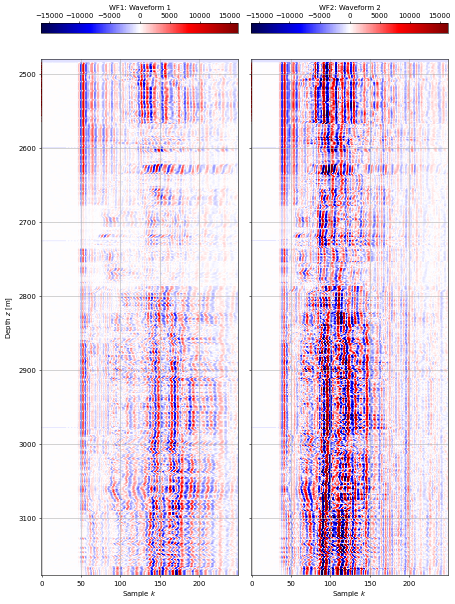

In [22]:
# Determine the maximum absolute value of WF1 and WF2 so that we can balance the colormap around 0
wf_max = max(np.max(np.abs(curves20B['WF1'])), np.max(np.abs(curves20B['WF2'])))
wf_lim = 0.5 * wf_max

# Parameters for plotting the waveforms
wf_pltargs = {
    'cmap': 'seismic',
    'vmin': -wf_lim,
    'vmax': wf_lim,
}

wf_samples = np.arange(wf1.dimension[0])   # x values to use in plotting

# Create figure and axes
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 12), constrained_layout=True)

# Plot WF1 as an image
ax = axes[0]
im = paint_channel(ax, curves20B['WF1'], curves20B[frame20B.index], wf_samples, **wf_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wf1.name}: {wf1.long_name}')
ax.set_ylabel('Depth $z$ [m]')

# Plot WF2 as an image
ax = axes[1]
im = paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_samples, **wf_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wf2.name}: {wf2.long_name}')

for ax in axes:
    ax.set_xlabel('Sample $k$')
    ax.grid(True)

This shows us the `WF1` and `WF2` waveforms recorded by the two receivers. These two channels do not have any units, so it is not yet clear how to convert them to physical units such as millivolts, except that it should involve some scaling factor.

We do not yet know which of these waveforms corresponds to the near and far receiver. Comparing them, we can make a few observations:

* The waveforms arrive earlier in `WF2` than in `WF1`.
* The waveforms are stronger in `WF2` than in `WF1`.
* Some components of the waveforms travel through fast paths and arrive early, while other components travel through slower paths and arrive later. The spread between the components is larger in `WF1` than in `WF2`, indicating that `WF1` has been measured further away.

These observations all tell us that `WF1` represents the far transducer at 5&nbsp;ft, while `WF2` represents the near transducer at 3&nbsp;ft.


### Finding the time axis of the sonic waveforms

While this shows us how to find the waveforms at every depth, we don't yet know what sampling rate they were measured at. Thus, we have no time axis for the waveforms. To solve this, let's look at time-related channels and parameters.

According to section Section 15-4.4.2.5 of [Well Cementing](https://www.slb.com/resource-library/book/well-cementing), the *transit time* represents the elapsed time between the transmitter firing a pulse and the first arrival of the pulse in the receiver. Among the sonic tool's channels, we have two transit time channels `TT1` and `TT2` in frame `20B`, which we can assume correspond to `WF1` and `WF2` respectively.

In [23]:
# Get the metadata related to TT1 and TT2
tt1 = get_channel(frame20B, 'TT1')
tt2 = get_channel(frame20B, 'TT2')

Let's assume that both waveforms start at $t=0$, when the transmitter fires the pulse. (This may also be what the `DDEL` ("Digitizing Delay") parameter tells us with its value of 0.) The `DSIN` ("Digitizer Sample Interval") parameter may be telling us that the sampling period is 10&nbsp;µs, corresponding to a sampling rate of 100&nbsp;kHz. To check this, we can assume these values to be true and see if we get a good fit between the transit times and the first arrivals in the waveforms.

In [24]:
wf_Ts = 10e-6     # Assumed waveform sampling period in seconds, i.e. time between samples
wf_Fs = 1/wf_Ts   # Assumed waveform sampling rate in Hertz, i.e. frequency of sampling
wf_t = wf_Ts * np.arange(wf1.dimension[0])   # Assumed time axis for the waveforms

To check whether our assumed sampling rate is correct, we can plot the travel time over the waveforms.

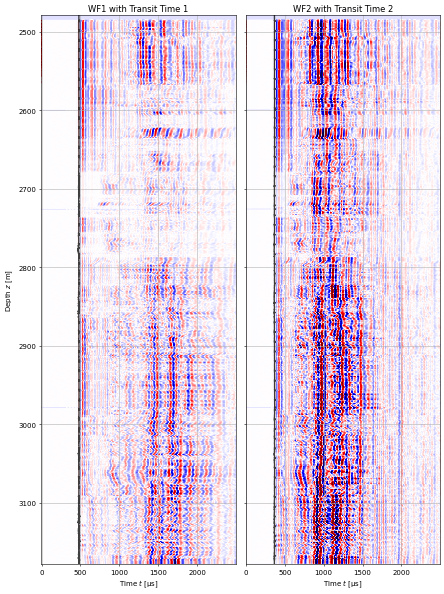

In [25]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 12))

# Plot WF1 as an image
ax = axes[0]
paint_channel(ax, curves20B['WF1'], curves20B[frame20B.index], wf_t*1e6, **wf_pltargs)
ax.plot(curves20B['TT1'], curves20B[frame20B.index], color='k', alpha=0.75, linewidth=2)
ax.set_ylabel('Depth $z$ [m]')
ax.set_title(f'{wf1.name} with {tt1.long_name}')

# Plot WF2 as an image
ax = axes[1]
paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_t*1e6, **wf_pltargs)
ax.plot(curves20B['TT2'], curves20B[frame20B.index], color='k', alpha=0.75, linewidth=2)
ax.set_title(f'{wf2.name} with {tt2.long_name}')

for ax in axes:
    ax.set_xlabel('Time $t$ [µs]')
    ax.grid(True)

fig.set_tight_layout(True)

A waveform sampling rate of 100&nbsp;kHz thus gives us an excellent correspondence between the travel time channels and the first arrivals in the waveforms. We have also validated our assumption that the receivers start recording at $t=0$, i.e. the pulse emission time.

We can also compare individual waveforms from `WF1` and `WF2` at the same depth:

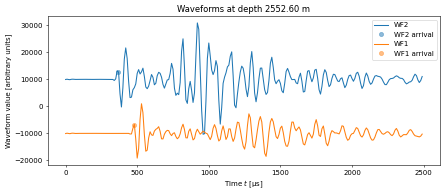

In [26]:
# Choose the depth index at which to plot the waveforms
i_wf = 12300

# Determine where to put the arrival times
tt2_t = curves20B['TT2'][i_wf]
tt2_y = np.interp(tt2_t, wf_t*1e6, curves20B['WF2'][i_wf, :])
tt1_t = curves20B['TT1'][i_wf]
tt1_y = np.interp(tt1_t, wf_t*1e6, curves20B['WF1'][i_wf, :])

shift = 1e4   # Vertical shift for both waveforms

fig, ax = plt.subplots(figsize=(9, 4))

[wf2_line] = ax.plot(wf_t*1e6, curves20B['WF2'][i_wf, :]+1e4, label='WF2')
ax.plot(tt2_t, tt2_y+shift, 'o', color=wf2_line.get_color(), alpha=0.5, label='WF2 arrival')

[wf1_line] = ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :]-1e4, label='WF1')
ax.plot(tt1_t, tt1_y-shift, 'o', color=wf1_line.get_color(), alpha=0.5, label='WF1 arrival')

ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.set_title(f'Waveforms at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.legend()
fig.set_tight_layout(True)

As mentioned, the waveform channels are stored without units, and there seems to be no parameter or channel available to convert the waveform values to any physical unit such as Pa or mV. While the `WF1N` ("Waveform 1 Normalization Factor") and `WF2N` ("Waveform 2 Normalization Factor") channels seem like promising candidates for this, they contain nothing but the value 1 at every depth.

We can also investigate the frequency content of these signals by performing the one-sided discrete Fourier transform and finding the spectral magnitude:

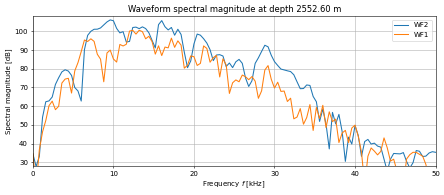

In [27]:
# Create a von Hann time window
n_samp = wf1.dimension[0]
hann_window = np.hanning(n_samp)

# Determine the spectral magnitude of the windowed signals
wf1_rfft = np.fft.rfft(hann_window*curves20B['WF1'][i_wf, :])
wf1_specmag = 20*np.log10(np.abs(wf1_rfft))
wf2_rfft = np.fft.rfft(hann_window*curves20B['WF2'][i_wf, :])
wf2_specmag = 20*np.log10(np.abs(wf2_rfft))
wf_f = np.fft.rfftfreq(n_samp, 10e-6)

wf_specmag_max = max(np.max(wf1_specmag), np.max(wf2_specmag))

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_f/1e3, wf2_specmag, label='WF2')
ax.plot(wf_f/1e3, wf1_specmag, label='WF1')
ax.set_ylim(wf_specmag_max - 78, wf_specmag_max + 2)
ax.set_xlim(0, 50)
ax.set_xlabel('Frequency $f$ [kHz]')
ax.set_ylabel('Spectral magnitude [dB]')
ax.set_title(f'Waveform spectral magnitude at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.legend()
ax.grid(True)
fig.set_tight_layout(True)

Based on these spectra, it seems that the recorded waveforms have most of their frequency content at roughly 6–22&nbsp;kHz. The emitted pulses may have more content at higher frequencies, as the waves will typically be more attenuated at higher frequencies on their way from the transmitter to the receivers. 

**Waveform summary:** `WF1` and `WF2` store acoustic waveforms recorded by the receivers at 5&nbsp;ft and 3&nbsp;ft, respectively. These waveforms are stored at sampling rates of 100&nbsp;kHz. There seems to be no straightforward way to convert the waveforms to any physical unit. `TT1` and `TT2` represent the arrival times of the first-arriving waveform components in `WF1` and `WF2`, respectively.


## Investigating the VDL channel

From the literature (e.g. the [Well Cementing](https://www.slb.com/resource-library/book/well-cementing) book), we know that a waveform display against depth, as plotted above, is often called a variable density log, or VDL. In fact, there is also a `VDL` channel in the files. This `VDL` channel has twice as many samples in time as the `WF1` and `WF2` channels. While the `VDL` channel is in the same frame as the `WF1` and `WF2` channels in this file, this is not true for every acoustic log file in Volve Data Village dataset. In other words, it may be sampled differently in both time and depth.

Let's investigate further, first by simply plotting the `VDL` channel as an image.

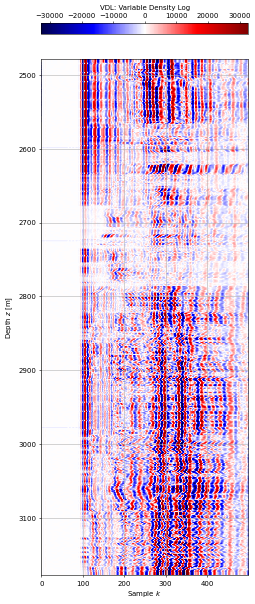

In [28]:
vdl = get_channel(frame20B, 'VDL')

# Determine the maximum absolute value of VDL so that we can balance the colormap around 0
vdl_max = np.max(np.abs(curves20B['VDL']))
vdl_lim = 1 * vdl_max

# Parameters for matplotlib.imshow
vdl_pltargs = {
    'cmap': 'seismic',
    'vmin': -vdl_lim,
    'vmax': vdl_lim,
}

vdl_samples = np.arange(vdl.dimension[0])

# Plot VDL
fig, ax = plt.subplots(figsize=(5,12), constrained_layout=True)
im = paint_channel(ax, curves20B['VDL'], curves20B[frame20B.index], vdl_samples, **vdl_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{vdl.name}: {vdl.long_name}')
ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('Sample $k$')
ax.grid(True)

From the image, the `VDL` channel seems to be very similar to the `WF1` channel from the 5&nbsp;ft receiver, albeit with twice the sampling rate (i.e. half the sampling period) and a different contrast. Let's investigate further by plotting a `VDL` waveform on top of a `WF1` waveform:

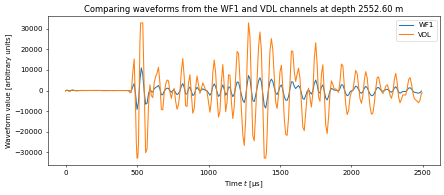

In [29]:
# Calculate the VDL time axis
vdl_Ts = wf_Ts/2
vdl_t = vdl_Ts * np.arange(vdl.dimension[0])

# Plot WF1 and VDL
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :], label='WF1')
ax.plot(vdl_t*1e6, curves20B['VDL'][i_wf, :], label='VDL')
ax.set_title(f'Comparing waveforms from the WF1 and VDL channels at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.legend()
fig.set_tight_layout(True)

It looks like `VDL` is simply a scaled version of `WF1`. Let's find a median scaling factor and compare again:

/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_37145/4213171325.py:1: RuntimeWarning: invalid value encountered in true_divide
  vdl_scaling = np.nanmedian(curves20B['VDL'][:, ::2] / curves20B['WF1'])


VDL/WF1 vdl_scaling factor: 4.55906976744186


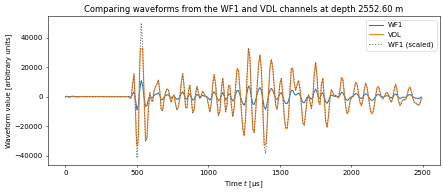

In [30]:
vdl_scaling = np.nanmedian(curves20B['VDL'][:, ::2] / curves20B['WF1'])
print('VDL/WF1 vdl_scaling factor:', vdl_scaling)

# Plot the comparison
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :], label='WF1')
ax.plot(vdl_t*1e6, curves20B['VDL'][i_wf, :], label='VDL')
ax.plot(wf_t*1e6, vdl_scaling*curves20B['WF1'][i_wf, :], ':', color='0.4', label='WF1 (scaled)')
ax.set_title(f'Comparing waveforms from the WF1 and VDL channels at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.legend()
fig.set_tight_layout(True)

We see that the scaled `WF1` and `VDL` waveforms overlap, except for the strongest peaks and troughs where `VDL` is clipped and the scaled `WF1` sticks out. Thus, we have confirmed that `VDL` is a scaled version of `WF1`, with twice the sampling rate. When `VDL` is scaled up enough, some of its sample values reach the maximum and minimum value that can be stored using the data type that the `VDL` channel is saved as in the DLIS file. As dlisio uses numpy datatypes equivalent to those used in the original DLIS file, we can simply interrogate the datatype to show this:

In [31]:
print(f'VDL value range: [{np.min(curves20B["VDL"])}, {np.max(curves20B["VDL"])}]')
print('Numpy datatype for the VDL channel:', curves20B['VDL'].dtype)
type_info = np.iinfo(curves20B['VDL'].dtype)
print(f'Range of {curves20B["VDL"].dtype}: [{type_info.min}, {type_info.max}]')

VDL value range: [-32767, 32767]
Numpy datatype for the VDL channel: int16
Range of int16: [-32768, 32767]


In other words, this scaling can cause the `VDL` channel data to be clipped, meaning that we are losing information about the strongest peaks and troughs. On the other hand, this clipping means that there is less difference between the strongest values in the `VDL` channel and the rest. This is the reason that the `VDL` looks like it has higher contrast than `WF1` when both are plotted as images.

**VDL summary:** `VDL` contains a scaled version of the same waveforms as the `WF1` channel, but at twice the sampling rate (200&nbsp;kHz) and sometimes with a different sampling in depth. It is not clear why these sampling differences exist, but there are two options: Either, the waveforms are originally recorded at a higher sampling rate and `WF1` and `WF2` are downsampled, or `VDL` is upsampled from `WF1`.


## Investigating the CBL channel

As the literature (e.g. the [Well Cementing](https://www.slb.com/resource-library/book/well-cementing) book) explains, the first-arriving component of the waveforms represents the fastest travel path from source to receiver. Typically, this path is where the emitted pulse travels through the casing fluid to the casing, where it excites a wave travelling along the casing, which in turn emits a wavefront back into the casing fluid that impinges on the receivers.

As the casing wave travels, it is attenuated due to energy loss into the casing fluid and the material outside the casing. With solids such as cement outside the casing, this attenuation is strong, which means that the first-arriving component will be much weaker than in cases with liquids such as water or mud outside the casing. Thus, the amplitude of the first-arriving component gives us an idea of the material outside the casing: High amplitudes correspond to fluids, and low amplitudes correspond to solids. (Middling amplitudes may correspond to solids partially covering the outside of the casing.)

This amplitude is quantified as the cement bond log (CBL), which is the amplitude $E_1$ in mV of the earliest detectable peak in the waveform signal recorded at the 3&nbsp;ft receiver. In our files, there is a `CBL` channel with units of mV, which we can compare against the `WF2` channel:

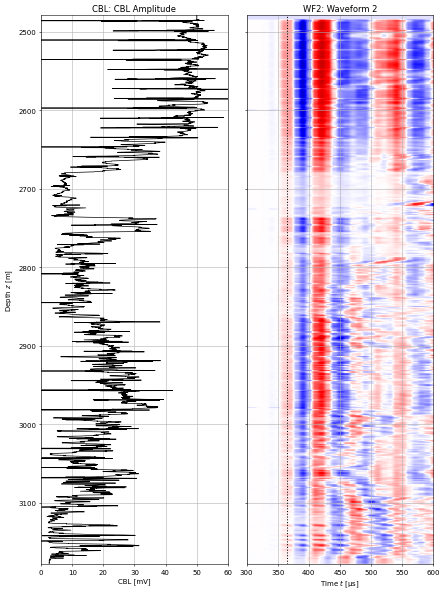

In [32]:
# The CBL channel is in frame 60B
frame60B = f.object('FRAME', '60B')
index60B = index_of(frame60B) 
curves60B = frame60B.curves()

# Convert the index to metres if needed
if index60B.units == '0.1 in':
    curves60B[index60B.name] *= 0.00254

# Get CBL channel metadata
cbl = get_channel(frame60B, 'CBL')

fig, axes = plt.subplots(ncols=2, figsize=(9, 12), sharey=True)

# Plot CBL
ax = axes[0]
ax.plot(curves60B['CBL'], curves60B[frame60B.index], color='k', linewidth=1)
ax.set_xlim(0, 60)
ax.set_xlabel('CBL [mV]')
ax.set_ylabel('Depth $z$ [m]')
ax.set_title(f'{cbl.name}: {cbl.long_name}')
ax.grid(True)

# Plot WF2 around the waveform arrival
ax = axes[1]
paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_t*1e6,
              vmin=-0.5*wf_max, vmax=0.5*wf_max, cmap='seismic')
ax.set_xlabel('Time $t$ [µs]')
ax.set_title(f'{wf2.name}: {wf2.long_name}')
ax.grid(True)
ax.set_xlim(300, 600)
ax.axvline(365, linestyle=':', color='k')

fig.set_tight_layout(True)

We thus see that the value of the `CBL` channel follows the amplitude of the first-arriving component in the `WF2` channel, roughly where the dotted line is:

* Where `WF2` is strong, `CBL` is high.
* Where `WF2` is faint, `CBL` is low.

The `CBL` channel also shows some sharp spikes around every 12th metre. This is due to the joints between casing sections, and we can see corresponding disturbances in the `WF2` channel.

CBL is typically roughly interpreted by thresholding. Very high values (depending on casing size and normalisation, but typically 50–60&nbsp;mV) indicate free pipe, i.e. only fluids on the outside of the casing. CBL values below around 10&nbsp;mV indicate solids fully covering the casing.

Because there does not seem to be any parameter that lets us convert the waveforms to units of mV, we cannot find the CBL directly from the waveforms. However, we can find the values of the $E_1$ peak in arbitrary units for every waveform to show that its overall shape matches the CBL curve. To do this, we:

* Upsample every `WF2` waveform using a Fourier method (which should be nearly exact, as we have seen that the signal is band-limited). One drawback of Fourier upsampling is that it assumes the signal to be periodic and can cause ringing if it is not, and we therefore enforce periodicity by applying a Tukey window to force the waveform to zero at its beginning and end.
* Find the peak sample of each waveform around the expected location of the peak
* Estimate the peak amplitude more finely by means of a quadratic fit around the three peak samples.

To be able to directly compare the $E_1$ values with the values in the `CBL` channel, we need to find a conversion factor $a$. Here, we simply find $a$ from a linear fit, with no intercept, between $E_1$ and `CBL`:

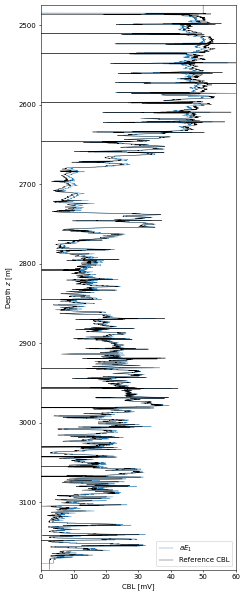

In [33]:
def waveform_E1(wfs, k_window):
    """Returns the first peak amplitudes E1 from an array of waveforms, searching only through samples in k_window"""
    n_wf = wfs.shape[0]
    wf_E1s = np.zeros(n_wf)
    
    for i in range(n_wf):
        k_max = k_window[0] + np.argmax(wfs[i][k_window])
        fit_ks = k_max + np.array([-1,0,1])
        fit = np.polyfit(fit_ks, wfs[i, fit_ks], 2)
        k_max = - fit[1] / (2 * fit[0])
        wf_E1s[i] = np.polyval(fit, k_max)

    return wf_E1s

# Determine E1 from the upsampled windowed waveforms
window = signal.tukey(250, 20/250)
upsampled_wfs, upsampled_wfs_t = signal.resample(window*curves20B['WF2'], 2500, wf_t, axis=1)
k_window = 365 + np.arange(-20, 21)
wf2_E1 = waveform_E1(upsampled_wfs, k_window)

# Interpolate waveform peaks to the CBL frame depths
wf2_E1 = np.interp(curves60B[frame60B.index], curves20B[frame20B.index][::-1], wf2_E1[::-1])

# Find a linear scaling between wf2_El and CBL as an intercept-free linear fit
mask = np.logical_and(curves60B['CBL'] > 0, wf2_E1 > 0)   # Omit missing data and invalid data
fit = np.linalg.lstsq(wf2_E1[mask][:,np.newaxis], curves60B['CBL'][mask], rcond=None)
a = fit[0][0]

# Plot comparison
fig, ax = plt.subplots(figsize=(5, 12))
ax.plot(wf2_E1*a, curves60B[frame60B.index], linewidth=0.5, label='$a E_1$')
ax.plot(curves60B['CBL'], curves60B[frame60B.index], 'k', linewidth=0.5, label='Reference CBL')
ax.set_xlim(0, 60)
ax.set_ylim(np.max(curves60B[frame60B.index]), np.min(curves60B[frame60B.index]))
ax.legend()
ax.set_xlabel('CBL [mV]')
ax.set_ylabel('Depth $z$ [m]');

fig.set_tight_layout(True)

Ignoring the spikes due to casing joints, we see that the $a E_1$ have the same shape as the reference `CBL` channel, but deviates for particularly large or small CBL values. We can check the match further by looking at how the scaling matches the joint distribution of $E_1$ and `CBL` values, and how the absolute difference $|aE_1 - \mathrm{CBL}|$ is distributed:

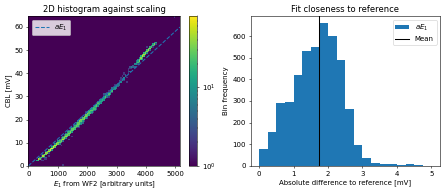

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_bad(cmap.colors[0])

# Plot a 2D histogram of E_1 values against the values from the CBL channel, and show the scaling
ax = axes[0]
plot_max = (max(wf2_E1), max(curves60B['CBL']))
hist = ax.hist2d(wf2_E1, curves60B['CBL'], norm=mpl.colors.LogNorm(), cmap=cmap,
                 bins=(np.linspace(0, plot_max[0], 100), np.linspace(0, plot_max[1], 100)))
ax.plot((0, plot_max[0]), (0, a*plot_max[0]), '--', label='$a E_1$')
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(0, plot_max[0])
ax.set_ylim(0, plot_max[1])
ax.set_title('2D histogram against scaling')
ax.set_xlabel('$E_1$ from WF2 [arbitrary units]')
ax.set_ylabel('CBL [mV]')
ax.legend()

# Plot a histogram showing the match
ax = axes[1]
x = np.abs(wf2_E1[mask]*a - curves60B['CBL'][mask])
ax.hist(x, bins=np.arange(0,5.25,0.25), label='$a E_1$')
ax.axvline(np.mean(x), color='k', label='Mean')
ax.legend()
ax.set_title('Fit closeness to reference')
ax.set_xlabel('Absolute difference to reference [mV]')
ax.set_ylabel('Bin frequency')

fig.set_tight_layout(True)

The 2D histogram shows a slight S-shape in the relation between $E_1$ and `CBL`, so that a conversion factor is not sufficient to connect the two. This implies that there is some kind of correction applied on the way from the waveform to the `CBL` channel. Among the sonic tool's channels, we find `CMCG` ('CBL Cement Type Compensation Gain'). Let's see what that looks like:

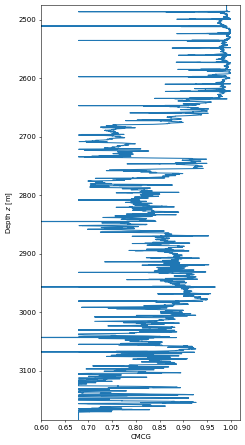

In [35]:
fig, ax = plt.subplots(figsize=(5,9))
ax.plot(curves60B['CMCG'], curves60B[frame60B.index])
ax.set_xlim(0.6, 1.02)
ax.set_ylim(np.max(curves60B[frame60B.index]), np.min(curves60B[frame60B.index]))
ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('CMCG')
fig.set_tight_layout(True)

Let's try using the `CMCG` channel to compensate our $E_1$ values before determining a conversion factor $a'$.

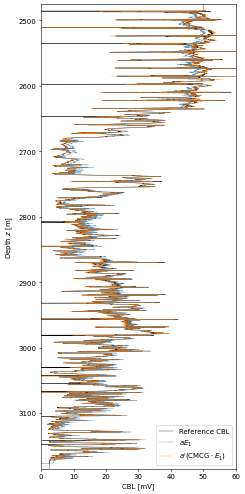

In [36]:
fit = np.linalg.lstsq((curves60B['CMCG']*wf2_E1)[mask][:,np.newaxis], curves60B['CBL'][mask], rcond=None)
aprime = fit[0][0]

fig, ax = plt.subplots(figsize=(5,10))
ax.plot(curves60B['CBL'], curves60B['TDEP'], 'k', linewidth=0.5, label='Reference CBL')
ax.plot(wf2_E1*a, curves60B['TDEP'], linewidth=0.5, alpha=0.75, label='$a E_1$')
ax.plot(curves60B['CMCG']*wf2_E1*aprime, curves60B['TDEP'], linewidth=0.5, alpha=0.75, label="$a' (\mathrm{CMCG} \cdot E_1)$")

ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('CBL [mV]')
ax.set_xlim(0, 60)
ax.set_ylim(np.max(curves60B[frame60B.index]), np.min(curves60B[frame60B.index]))
ax.legend()

fig.set_tight_layout(True)

This gives us a much better fit. Let's have a closer look through the same kind of histograms as we used earlier:

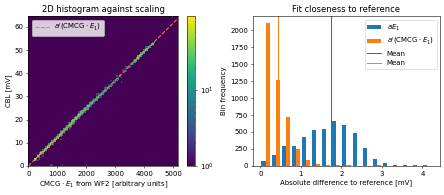

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

# Plot a 2D histogram of corrected E_1 values against the values from the CBL channel, and show the scaling
ax = axes[0]
plot_max = (max(wf2_E1), max(curves60B['CBL']))
hist = ax.hist2d(curves60B['CMCG']*wf2_E1, curves60B['CBL'], norm=mpl.colors.LogNorm(), cmap=cmap,
                 bins=(np.linspace(0, plot_max[0], 100), np.linspace(0, plot_max[1], 100)))
ax.plot((0, plot_max[0]), (0, aprime*plot_max[0]), '--', color='C1', label="$a'(\mathrm{CMCG} \cdot E_1)$")
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(0, plot_max[0])
ax.set_ylim(0, plot_max[1])
ax.set_title('2D histogram against scaling')
ax.set_xlabel('$\mathrm{CMCG} \cdot E_1$ from WF2 [arbitrary units]')
ax.set_ylabel('CBL [mV]')
ax.legend()

# Plot a histogram showing the match
ax = axes[1]
x = [np.abs(wf2_E1[mask]*a - curves60B['CBL'][mask]),
     np.abs((curves60B['CMCG']*wf2_E1*aprime)[mask] - curves60B['CBL'][mask])]
ax.hist(x, bins=np.arange(0,4.5,0.25), label=['$a E_1$', "$a' (\mathrm{CMCG} \cdot E_1)$"])
ax.axvline(np.mean(x[0]), color='C0', label='Mean')
ax.axvline(np.mean(x[1]), color='C1', label='Mean')
ax.legend()
ax.set_title('Fit closeness to reference')
ax.set_xlabel('Absolute difference to reference [mV]')
ax.set_ylabel('Bin frequency')

fig.set_tight_layout(True)

**CBL summary:** It is possible to determine CBL values from the first peak amplitudes $E_1$ from the `WF2`waveforms, although there are some issues with this. The main issue is that the waveforms in the `WF2` and `WF1` channels are stored in arbitrary units instead of mV, and the files contain no obvious way to convert the units. Second, a straightforward implementation of this would not match the `CBL` channel in the file that well, as the `CBL` values have undergone some correction, related to the `CMCG` channel, that we at this point do not know how to calculate from scratch.

## Attenuation rate and bond index

While CBL tells us of the attenuation accumulated by the casing wave as it travels along the casing, we can also estimate this attenuation directly when we have two or more receivers. From the [Well Cementing](https://www.slb.com/resource-library/book/well-cementing) book, we find that attenuation can be estimated from $E_1$ in the near and far receivers as

$$\alpha = \frac{20}{L_\mathrm{RR}} \log_{10}\left( \frac{E_{1,\mathrm{near}}}{E_{1,\mathrm{far}}} \right) ,$$ 

where $L_\mathrm{RR}$ is the distance between receivers (2 feet in our case). If only one receiver is availabel at a distance $L_\mathrm{TR}$ from the transducer, the attenuation can still be approximated as

$$\alpha' = \frac{20}{L_\mathrm{TR}} \log_{10}\left( \frac{E_{1,\mathrm{free}}}{E_1} \right) ,$$ 

where $E_{1,\mathrm{free}}$ is the amplitude for free-pipe intervals in the same receiver as $E_1$ is measured. For the near receiver, a reference amplitude is given in the file in the `CBRA` (‘CBL LQC Reference Amplitude in Free Pipe’) parameter.

A common way of representing these attenuations is through the *bond index* BI, which scales and shifts the attenuation to lie between 0 and 1 as

$$\mathrm{BI} = \frac{\alpha - \alpha_\mathrm{free}}{\alpha_\mathrm{full} - \alpha_\mathrm{free}} ,$$

where $\alpha_\mathrm{free}$ is the attenuation in free-pipe intervals and $\alpha_\mathrm{full}$ is the attenuation in intervals where the casing is fully covered by bonded solids. Thus, $\mathrm{BI} = 0$ corresponds to no coverage and $\mathrm{BI} = 1$ corresponds to full coverage. The idea is that $\mathrm{BI}$ should correspond to the proportion of casing covered by bonded solids.

If only one casing is available, we can calculate an approximate bond index as

$$\mathrm{BI}' = \frac{\alpha' - \alpha_\mathrm{free}}{\alpha_\mathrm{full} - \alpha_\mathrm{free}} .$$

Additionally, we can calculate the alternative *bond percentage index* as

$$\mathrm{BPI} = \frac{E_{1,\mathrm{free}} - E_1}{E_{1,\mathrm{free}} - E_{1,\mathrm{full}}} ,$$

where $E_{1,\mathrm{full}}$ is the amplitude for full-coverage intervals in the same receiver as $E_1$ is measured. We find this from the parameter `MSA` (‘Minimum Sonic Amplitude’).

Before we do this, we must calculate $E_1$ for the far receiver, i.e. from the waveforms in the `WF1` channel. We do this in the same way as from `WF2`:

In [38]:
# Calculate the first peak values E_1 from the WF1 waveforms
upsampled_wfs, upsampled_wfs_t = signal.resample(window*curves20B['WF1'], 2500, wf_t, axis=1)
k_window = np.arange(465, 489)
wf1_E1 = waveform_E1(upsampled_wfs, k_window)

# Interpolate waveform peaks to the CBL frame depths
wf1_E1 = np.interp(curves60B[frame60B.index], curves20B[frame20B.index][::-1], wf1_E1[::-1])

Now we can calculate the attenuations and bond indices, and compare them against each other and the file's channel `BI` (‘Bond Index’) by plotting:

/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_37145/2125932976.py:14: RuntimeWarning: invalid value encountered in log10
  attenuation = 20/L_RR * np.log10(E1_near/E1_far)
/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_37145/2125932976.py:15: RuntimeWarning: invalid value encountered in log10
  attenuation_approx = 20/L_TR * np.log10(E1_free/E1_near)


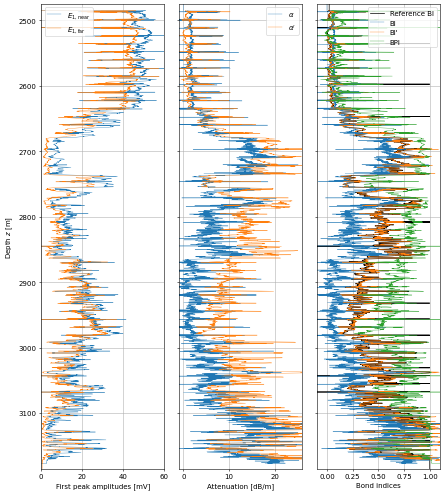

In [39]:
# Calculate corrected E1 values for the near and far receivers
E1_near = aprime*curves60B['CMCG']*wf2_E1
E1_far = aprime*curves60B['CMCG']*wf1_E1

# Calculate near receiver reference values
E1_free = f.object('PARAMETER', 'CBRA').values[0]   # Free pipe
E1_full = f.object('PARAMETER', 'MSA').values[0]    # Full solid coverage

# Calculate distances between transducers
L_RR = (5-3)*0.3048   # Near and far receivers
L_TR = 3*0.3048       # Transmitter and near receiver

# Calculate full attenuation and approximate attenuation based only on the near receiver
attenuation = 20/L_RR * np.log10(E1_near/E1_far)
attenuation_approx = 20/L_TR * np.log10(E1_free/E1_near)

# Calculate reference attenuation values for free pipe and full coverage of solids
attenuation_free = 0
attenuation_full = 20/L_TR * np.log10(E1_free/E1_full)

# Calculate bond index, approximate bond index based on the near receiver, and bond percentage index
BI = (attenuation - attenuation_free) / (attenuation_full - attenuation_free)
BI_approx = (attenuation_approx - attenuation_free) / (attenuation_full - attenuation_free)
BPI = (E1_free - E1_near) / (E1_free - E1_full)

fig, axes = plt.subplots(figsize=(9,10), ncols=3, sharey=True)

# Plot E1
ax = axes[0]
ax.plot(E1_near, curves60B[frame60B.index], linewidth=0.5, label='$E_{1,\mathrm{near}}$')
ax.plot(E1_far, curves60B[frame60B.index], linewidth=0.5, label='$E_{1,\mathrm{far}}$')
ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('First peak amplitudes [mV]')
ax.legend(loc='upper left')
ax.set_xlim(0, 60)

# Plot attenuation
ax = axes[1]
ax.plot(attenuation, curves60B[frame60B.index], linewidth=0.5, label='$\\alpha$')
ax.plot(attenuation_approx, curves60B[frame60B.index], linewidth=0.5, label="$\\alpha'$")
ax.set_xlabel('Attenuation [dB/m]')
ax.set_xlim(-1, 26)
ax.legend()

# Plot bond indices
ax = axes[2]
ax.plot(curves60B['BI'], curves60B[frame60B.index], 'k', linewidth=1, label='Reference BI')
ax.plot(BI, curves60B[frame60B.index], linewidth=0.5, label='BI')
ax.plot(BI_approx, curves60B[frame60B.index], linewidth=0.5, label="BI'")
ax.plot(BPI, curves60B[frame60B.index], linewidth=0.5, label='BPI')
ax.set_xlabel('Bond indices')
ax.set_xlim(-0.1, 1.1)
ax.legend()

# Set the y limits from the bottom to the top of the logged interval
ax.set_ylim(max(curves60B[frame60B.index]), min(curves60B[frame60B.index]))

for ax in axes:
    ax.grid(True)
fig.set_tight_layout(True)

The approximate attenuation $\alpha'$ is higher than the attenuation $\alpha$ calculated from both receivers. This is reflected in the approximate bond index $\mathrm{BI}'$ being higher than the bond index $\mathrm{BI}$ calculated from both receivers. The reference from the `BI` channel matches $\mathrm{BI}'$ well, with the minor deviations originating from us calculating $\mathrm{BI'}$ based on our own $E_1$ processing instead of from the `CBL` channel. $\mathrm{BPI}$ predicts a higher coverage than the other bond metrics.

**Attenuation summary:** From the waveforms in the `WF1` and `WF2` channels, we can compute various attenuation and bond metrics that are not provided in the file.

# Investigating the ultrasonic tool

The ultrasonic tool's name is "USIT", which is short for "Ultrasonic Imaging Tool". It was first described in [a 1991 article by Hayman et al.](https://www.onepetro.org/conference-paper/SPWLA-1991-KK), and some further details are described in Section 15-4.5 of the aforementioned [Well Cementing](https://www.slb.com/resource-library/book/well-cementing) book.

The basic mechanism of the USIT (and similar pulse-echo tools) is that an ultrasonic transducer emits a pulse onto the casing at normal incidence. A small part of the pulse is transmitted into the casing, where it resonates. The reflected pulse is then recorded by the transducer. The recorded pulse consists of the strong first reflection from the fluid-casing interface, known as the first-interface echo (FIE), followed by a decaying resonance. Based on a single pulse, the USIT can estimate the distance from the transducer to the casing, the thickness $d$ of the casing, and the acoustic impedance $Z = \rho c$ of the material on the far side of the casing, where $\rho$ and $c$ are the material's density and pressure wave speed, respectively. Furthermore, if the transducer position is known, the transducer-casing distance allows calculating the inner radius $r_\mathrm{i}$ of the casing, which can be combined with the thickness $d$ to give the outer radius $r_\mathrm{o} = r_\mathrm{i} + d$.

The USIT head rotates very quickly as the tool moves through the well, so that the transducer can emit its pulses at different azimuthal angles. This means that unlike the sonic tool, which can only sample the well in depth, the USIT can sample the well in both depth and azimuthal angle. The USIT's angular resolution can be set to either 5° (360°/5° = 72 measurements per depth) or 10° (360°/10° = 36 measurements per depth).

The processing algorithm giving the casing thickness and the acoustic impedance behind the casing is called *Traitement Très Tôt* ("very early processing" in French), or simply T<sup>3</sup>. This algorithm is described in the two sources mentioned above. Although the data in the file would let us recreate this processing, we will not go into that in this notebook.

First, let us look at what data the USIT tool gives us:

In [40]:
usit = f.object('TOOL', 'USIT')
usit.describe()

----
Tool
----
name   : USIT
origin : 57
copy   : 0

Description    : Ultrasonic Imaging
Trademark name : USIT-E
Generic name   : USIT-E

Channels   : AWAV_RF                  MDR                      U044
             U016                     U023                     U036
             U008                     AIMN_RF                  RB
             U022                     AZEC_EXT                 IDQC
             RSAV                     AWAV                     U020
             U024                     U051                     IRAV_EXT
             T2BK                     IRMN_EXT                 AWMN_RF
             U063                     U027                     U009
             U014                     U035                     WPKA
             AZEC                     U056                     THBK
             AI_MICRO_DEBONDING_IMAGE GASR                     IRBK
             CZMD                     IRMN                     ERMN
             USGI                     U04

Now, let's look at the USIT parameters:

In [41]:
usit_param_table = summarize(usit.parameters, name='Name', long_name='Long name', values='Value(s)')
usit_param_table.sort_values('Name')

Name                                          Long name  \
36            AFVU                    Automatic Fluid Velocity Update   
46            AGMN                          Minimum Gain of Cartridge   
47            AGMX                          Maximum Gain of Cartridge   
7             BERJ                                 Bad Echo Rejection   
17            CMTY                                        Cement Type   
41          C_ALGO                         Collar detection algorithm   
38         C_BLANK         Ignore on each side of each collar, inches   
3           C_DLEN                    Collar detection length, inches   
44           C_JNO                                Joint number offset   
34         C_MFILT         Apply 3-point median filter to statistics?   
0            C_MPL                        Minimum pipe length, inches   
29           C_NUP                         Number joints from bottom?   
11           C_TPC              Collar detection threshold percentage   
20          C_WIND             Collar detection window length, inches   
42             DOT                      Diameter of Transducer Sensor   
28            EMXV                                       EMEX Voltage   
8          ENABLED        Equipment or Computation Acquisition Status   
21         ENABLED        Equipment or Computation Acquisition Status   
5          ENABLED        Equipment or Computation Acquisition Status   
23         ENABLED        Equipment or Computation Acquisition Status   
4          ENABLED        Equipment or Computation Acquisition Status   
15         ENABLED        Equipment or Computation Acquisition Status   
26         ENABLED        Equipment or Computation Acquisition Status   
27            HRES                              Horizontal Resolution   
9   MAX_TOOL_SPEED  Maximum service speed allowed for, or attained...   
13            NPPW                      Number of Points Per Waveform   
18            NWPD                      Number of Waveforms per Depth   
32           OPLEV                     USIT Remove Flagged Data Level   
10            RCOD                Reference Calibrator Outer Diameter   
12            RCSO                      Reference Calibrator Standoff   
1             RCTH                     Reference Calibrator Thickness   
25            SDNV  Number of Vertical Samples used for Micro-debo...   
48          SDTHOR  Acoustic Impedance STD Horizontal Threshold fo...   
49          SDTVER  Acoustic Impedance STD Vertical Threshold for ...   
50            SUBT                                      USIT Sub type   
16            TCUB                               T^3 Processing Level   
37            THDH   Maximum Search Thickness (percentage of nominal)   
14            THDL   Minimum Search Thickness (percentage of nominal)   
35            THDP                         Thickness Detection Policy   
45             TVD                                True Vertical Depth   
56     U-USIT_DDT5               USIC Downhole Decimation for T5 only   
51            ULOG                                  Logging Objective   
52            UMAO                    USIT Measurement Angular Offset   
24            UMFR                               Modulation Frequency   
53            UPAT                                   Emission Pattern   
39            USFR                      Ultrasonic Sampling Frequency   
54            USTO                                   USIT Time Offset   
55            USUB                                USIT Sub Identifier   
57            UWKM                                       Working Mode   
6             VCAS          Ultrasonic Transversal Velocity in Casing   
19            VRES                                Vertical Resolution   
40            WINB                                  Window Begin Time   
31            WINE                                    Window End Time   
2             WLEN                              T^3 Processing Length   

Finally, here are the USIT channels:

In [42]:
usit_channel_table = summarize(usit.channels, name='Name', long_name='Long name', units='Units',
                                              dimension='Dimension', frame='Frame')
usit_channel_table.sort_values('Name')

Name  \
88                       AGMA   
54                       AGMI   
112                      AIAV   
98                    AIAV_RF   
49                       AIBK   
89                       AIMN   
7                     AIMN_RF   
55                       AIMX   
90                    AIMX_RF   
30   AI_MICRO_DEBONDING_IMAGE   
13                       AWAV   
0                     AWAV_RF   
132                      AWBK   
147                   AWBK_RF   
133                      AWMN   
20                    AWMN_RF   
106                      AWMX   
120                   AWMX_RF   
27                       AZEC   
10                   AZEC_EXT   
141                   AZEC_RF   
61                       BPRE   
50                       CCLU   
137                      CEMR   
56                       CFVL   
33                       CZMD   
44                       ECCE   
45                 ECCEEXT_RF   
96                   ECCE_EXT   
110                   ECCE_RF   
128                      ERAV   
127                  ERAV_EXT   
148                   ERAV_RF   
107                  ERBA_EXT   
142                      ERBK   
134                  ERBK_EXT   
83                   ERBN_EXT   
35                       ERMN   
53                   ERMN_EXT   
149                   ERMN_RF   
85                       ERMX   
73                   ERMX_EXT   
150                   ERMX_RF   
104                      ERNO   
31                       GASR   
151                      GNMN   
152                      GNMX   
153                      HRTT   
11                       IDQC   
79                       IRAV   
17                   IRAV_EXT   
154                   IRAV_RF   
32                       IRBK   
144                  IRBK_EXT   
155                   IRBK_RF   
34                       IRMN   
19                   IRMN_EXT   
156                   IRMN_RF   
105                      IRMX   
124                  IRMX_EXT   
157                   IRMX_RF   
82                       IRNO   
1                         MDR   
158                     MLOSS   
8                          RB   
159                   RB_USIT   
12                       RSAV   
101                      T1BK   
108                      T2AV   
18                       T2BK   
160                      THAV   
161                   THAV_RF   
29                       THBK   
162                   THBK_RF   
163                      THMN   
164                   THMN_RF   
165                      THMX   
166                   THMX_RF   
116                      THNO   
167                      TTAV   
46                       TTBK   
168                      TTMN   
169                      TTMX   
170                     U-ED1   
171                    U-ED10   
172                    U-ED11   
173                    U-ED12   
174                    U-ED13   
175                    U-ED14   
176                    U-ED15   
177                    U-ED16   
178                    U-ED17   
179                    U-ED18   
180                    U-ED19   
181                     U-ED2   
182                    U-ED20   
183                    U-ED21   
184                    U-ED22   
185                    U-ED23   
186                    U-ED24   
187                    U-ED25   
188                    U-ED26   
189                    U-ED27   
190                    U-ED28   
191                    U-ED29   
192                     U-ED3   
193                    U-ED30   
194                    U-ED31   
195                    U-ED32   
196                    U-ED33   
197                    U-ED34   
198                    U-ED35   
199                    U-ED36   
200                     U-ED4   
201                     U-ED5   
202                     U-ED6   
203                     U-ED7   
204                     U-ED8   
205                     U-ED9   
208                     U-ID1   
209                    U-ID10   

From the much larger number of parameters and channels, it is clear that there is a lot more information available from the USIT than the DSLT.


## Investigating basic azimuthal channels

To start making sense of this information, we can see that many of the USIT channels have a dimension corresponding to the value of the `NWPD` (‘Number of Waveforms per Depth’) parameter. (`NWPD` has values of 72 or 36 in the Volve integrity log files). These channels represent the results of processing the measured waveforms, with each of the 72 or 36 values per depth representing a measurement at a different azimuthal angle. Let's show all of them:

In [43]:
# Get the value of the NWPD parameter
nwpd = f.object('PARAMETER', 'NWPD').values[0]

# Show all azimuthal channels
usit_channel_table[usit_channel_table['Dimension'] == nwpd].sort_values('Name')

Name  \
49                       AIBK   
30   AI_MICRO_DEBONDING_IMAGE   
132                      AWBK   
147                   AWBK_RF   
107                  ERBA_EXT   
142                      ERBK   
134                  ERBK_EXT   
83                   ERBN_EXT   
32                       IRBK   
144                  IRBK_EXT   
155                   IRBK_RF   
101                      T1BK   
18                       T2BK   
29                       THBK   
162                   THBK_RF   
46                       TTBK   
206                      UFLG   
42                       UPGA   
113                      UTIM   
119                      WAGN   
51                       WFDL   
26                       WPKA   

                                             Long name  Units Dimension  \
49                                  Acoustic Impedance  Mrayl      [72]   
30       Acoustic Impedance With Micro-debonding Image  Mrayl      [72]   
132                                  Amplitude of Wave     dB      [72]   
147    Unflagged Echo Amplitude minus median amplitude     dB      [72]   
107  External Radii Corrected for External Eccenter...     in      [72]   
142                                     External Radii     in      [72]   
134  External Radii Corrected for External Eccentering     in      [72]   
83   External Radii Corrected for External Eccenter...     in      [72]   
32                           Internal Radii Normalized     in      [72]   
144  Internal Radii Corrected for External Eccentering     in      [72]   
155                 Unflagged External Radii of Casing     in      [72]   
101                         Internal Radius Metal Loss     in      [72]   
18                   Thickness of Casing minus Nominal     in      [72]   
29                         Casing Thickness Normalized     in      [72]   
162             Image of Unflagged Thickness of Casing     in      [72]   
46                                        Transit Time     us      [72]   
206                              USIT Processing Flags             [72]   
42           USIC Programmable Gain Amplitude of Waves     dB      [72]   
113                           Time of Arrival of Waves     ms      [72]   
119                              Waveform Applied Gain     dB      [72]   
51                                      Waveform Delay     us      [72]   
26                             Waveform Peak Amplitude             [72]   

          Frame  
49   Frame(60B)  
30   Frame(60B)  
132  Frame(60B)  
147  Frame(60B)  
107  Frame(60B)  
142  Frame(60B)  
134  Frame(60B)  
83   Frame(60B)  
32   Frame(60B)  
144  Frame(60B)  
155  Frame(60B)  
101  Frame(60B)  
18   Frame(60B)  
29   Frame(60B)  
162  Frame(60B)  
46   Frame(60B)  
206  Frame(60B)  
42   Frame(60B)  
113  Frame(60B)  
119  Frame(60B)  
51   Frame(60B)  
26   Frame(60B)

There are a lot of channels here that sound similar (for example several channels to do with internal and external radii of the casing), but there are some we can pick out immediately based on what information we know should be present:

* `AIBK` (‘Acoustic Impedance’) should represent the estimated impedance of the material behind the casing.
* `IRBK` (‘Internal Radii Normalized’) should represent the internal radius, with some kind of normalisation.
* `T2BK` (‘Thickness of Casing minus Nominal’) should represent the difference between the actual casing thickness and the nominal casing thickness, which is stored in the parameter `THNO`.
* `ERBK` (‘External Radii’) should represent the external radius of the casing.

Let's load these channels to investigate them further:

In [44]:
# All the Channels we want are in Frame(60B)
frame60B = f.object('FRAME', '60B')
index60B = index_of(frame60B) 
curves60B = frame60B.curves()

# Convert the index to metres if needed
if index60B.units == '0.1 in':
    curves60B[index60B.name] *= 0.00254

# Get the metadata of each channel
aibk = get_channel(frame60B, 'AIBK')
t2bk = get_channel(frame60B, 'T2BK')
erbk = get_channel(frame60B, 'ERBK')
irbk = get_channel(frame60B, 'IRBK')

Each array corresponding to the channel curves, e.g. $\mathtt{AIBK}(i,j)$, has two dimensions. The first dimension, which we represent by the index $i$, is depth. The second, which we represent by the index $j$, is the azimuthal angle. The actual azimuthal angle is given from the `NWPD` parameter as $\varphi_j = j \Delta \varphi$, where $\Delta\varphi = 360/\mathrm{NWPD}$:

In [45]:
dang = 360//nwpd
ang = dang * np.arange(nwpd)

Now we can plot the data from these four channels:

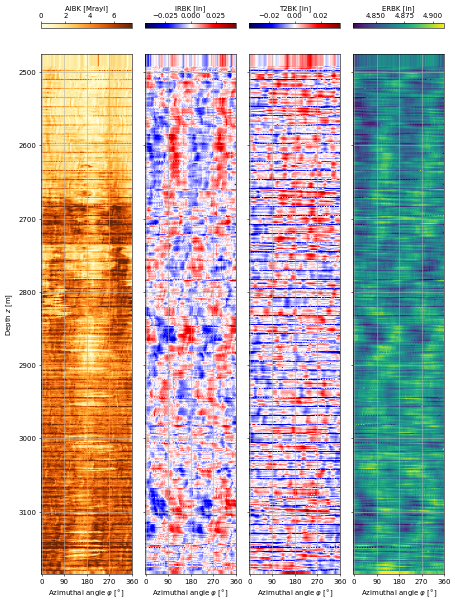

In [46]:
fig, axes = plt.subplots(ncols=4, figsize=(9,12), sharey=True, constrained_layout=True)

ax = axes[0]
im = paint_channel(ax, curves60B['AIBK'], curves60B[frame60B.index], ang, cmap='YlOrBr', vmin=0, vmax=7.5)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'AIBK [{aibk.units}]')
ax.set_ylabel('Depth $z$ [m]')

ax = axes[1]
im = paint_channel(ax, curves60B['IRBK'], curves60B[frame60B.index], ang, cmap='seismic', vmin=-0.045, vmax=0.045)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'IRBK [{irbk.units}]')

ax = axes[2]
im = paint_channel(ax, curves60B['T2BK'], curves60B[frame60B.index], ang, cmap='seismic', vmin=-0.035, vmax=0.035)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'T2BK [{t2bk.units}]')

ax = axes[3]
im = paint_channel(ax, curves60B['ERBK'], curves60B[frame60B.index], ang, vmin=4.83, vmax=4.91)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'ERBK [{erbk.units}]')

for ax in axes:
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.grid(True)
    ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')

The three latter channels provide information about the geometry of the casing. `T2BK`, together with the nominal thickness parameter `THNO` give us the casing thickness as

$$d(z_i,\varphi_j) = \mathtt{T2BK}(i,j) + \mathtt{THNO} ,$$

while the `ERBK` channel directly gives us the casing outer radius as

$$r_\mathrm{o}(z_i,\varphi_j) = \mathtt{ERBK}(i,j) .$$

However, the long name of the `IRBK` channel, "Internal Radii Normalized", refers to some as of yet unknown normalisation. Using Schlumberger's [Curve Mnemonic Dictionary](https://www.apps.slb.com/cmd/index.aspx) to look up [IRBK](https://www.apps.slb.com/cmd/ChannelItem.aspx?code=IRBK), we find that the channel has the property [Differential_Radius](https://www.apps.slb.com/cmd/PropertyItem.aspx?code=Differential_Radius), which means that it represents the difference between the actual radius of an object and its average radius. Looking at the list of channels for something giving an average radius, we can find the `IRAV` ("Internal Radius Averaged Value") curve channel. We may then guess that we can find the actual internal radius as

$$r_\mathrm{i}(z_i,\varphi_j) = \mathtt{IRAV}(i) + \mathtt{IRBK}(i,j) .$$

To check this guess, we can compare two methods of finding the internal radius and check if

$$r_\mathrm{i}(z_i,\varphi_j) = r_\mathrm{o}(z_i,\varphi_j) - d(z_i,\varphi_j) :$$

In [47]:
# Casing thickness
thno = f.object('PARAMETER', 'THNO').values[0]
d = curves60B['T2BK'] + thno

# Outer casing radius
r_o = curves60B['ERBK']

# Inner casing radius?
r_i = curves60B['IRAV'][:, np.newaxis] + curves60B['IRBK'][:, :]

print('Maximum absolute difference between the two internal radius approaches:', np.max(np.abs(r_i - (r_o - d))))
print(f'Machine epsilon for {curves60B["IRBK"].dtype} values: {np.finfo(curves60B["IRBK"].dtype).eps}')

Maximum absolute difference between the two internal radius approaches: 4.7683716e-07
Machine epsilon for float32 values: 1.1920928955078125e-07


As the difference between the two methods is on the order of machine epsilon for the float32 variables used in the data channels, we have confirmed that both these methods agree on the internal radius, with the only differences caused by roundoff error.

We can use this geometry data to plot the casing geometry at a particular depth:

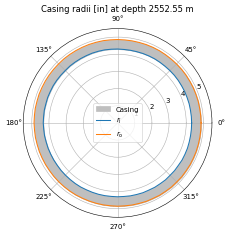

In [48]:
# Depth index to plot geometry for
i_geom = 4150

# Find closed curves for the inner and outer radii, as well as for the azimuthal angles in radians
r_i_closed = np.concatenate((r_i[i_geom, :], r_i[i_geom, 0][np.newaxis]))
r_o_closed = np.concatenate((r_o[i_geom, :], r_o[i_geom, 0][np.newaxis]))
ang_closed = np.concatenate((ang, ang[0][np.newaxis])) * 2*np.pi/360

fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True), facecolor='white')

ax.fill_between(ang_closed, r_i_closed, r_o_closed, color='0.75', label='Casing')
ax.plot(ang_closed, r_i_closed, label='$r_\mathrm{i}$')
ax.plot(ang_closed, r_o_closed, label='$r_\mathrm{o}$')
ax.set_ylim(0, 5.5)
ax.legend()
ax.set_title(f'Casing radii [in] at depth {curves60B[frame60B.index][i_geom]:.2f} m');

**Azimuthal channel summary:** At every depth, a number of channels store one value per azimuthal angle measured by the ultrasonic tool. For example, the `IRBK`, `T2BK`, and `ERBK` channels store information that, together with the `IRAV` channel that only stores one value per depth, can be used to find the inner radius, thickness, and outer radius of the casing at every depth and angle.


## Investigating ultrasonic waveforms

The file also contains channels of USIT waveforms, named `U001`, `U002`, and so forth. The number of such channels equals the `NWPD` ("Number of Waveforms per Depth") parameter:

In [49]:
usit_channel_table[usit_channel_table['Name'].str.contains('U0')].sort_values('Name')

Name                Long name Units Dimension       Frame
39   U001  Waveform for Azimuth 01           [120]  Frame(60B)
59   U002  Waveform for Azimuth 02           [120]  Frame(60B)
136  U003  Waveform for Azimuth 03           [120]  Frame(60B)
87   U004  Waveform for Azimuth 04           [120]  Frame(60B)
117  U005  Waveform for Azimuth 05           [120]  Frame(60B)
57   U006  Waveform for Azimuth 06           [120]  Frame(60B)
81   U007  Waveform for Azimuth 07           [120]  Frame(60B)
6    U008  Waveform for Azimuth 08           [120]  Frame(60B)
23   U009  Waveform for Azimuth 09           [120]  Frame(60B)
97   U010  Waveform for Azimuth 10           [120]  Frame(60B)
38   U011  Waveform for Azimuth 11           [120]  Frame(60B)
93   U012  Waveform for Azimuth 12           [120]  Frame(60B)
95   U013  Waveform for Azimuth 13           [120]  Frame(60B)
24   U014  Waveform for Azimuth 14           [120]  Frame(60B)
65   U015  Waveform for Azimuth 15           [120]  Frame(60B)
3    U016  Waveform for Azimuth 16           [120]  Frame(60B)
100  U017  Waveform for Azimuth 17           [120]  Frame(60B)
60   U018  Waveform for Azimuth 18           [120]  Frame(60B)
66   U019  Waveform for Azimuth 19           [120]  Frame(60B)
14   U020  Waveform for Azimuth 20           [120]  Frame(60B)
78   U021  Waveform for Azimuth 21           [120]  Frame(60B)
9    U022  Waveform for Azimuth 22           [120]  Frame(60B)
4    U023  Waveform for Azimuth 23           [120]  Frame(60B)
15   U024  Waveform for Azimuth 24           [120]  Frame(60B)
76   U025  Waveform for Azimuth 25           [120]  Frame(60B)
115  U026  Waveform for Azimuth 26           [120]  Frame(60B)
22   U027  Waveform for Azimuth 27           [120]  Frame(60B)
126  U028  Waveform for Azimuth 28           [120]  Frame(60B)
75   U029  Waveform for Azimuth 29           [120]  Frame(60B)
91   U030  Waveform for Azimuth 30           [120]  Frame(60B)
129  U031  Waveform for Azimuth 31           [120]  Frame(60B)
102  U032  Waveform for Azimuth 32           [120]  Frame(60B)
68   U033  Waveform for Azimuth 33           [120]  Frame(60B)
131  U034  Waveform for Azimuth 34           [120]  Frame(60B)
25   U035  Waveform for Azimuth 35           [120]  Frame(60B)
5    U036  Waveform for Azimuth 36           [120]  Frame(60B)
109  U037  Waveform for Azimuth 37           [120]  Frame(60B)
72   U038  Waveform for Azimuth 38           [120]  Frame(60B)
135  U039  Waveform for Azimuth 39           [120]  Frame(60B)
67   U040  Waveform for Azimuth 40           [120]  Frame(60B)
111  U041  Waveform for Azimuth 41           [120]  Frame(60B)
37   U042  Waveform for Azimuth 42           [120]  Frame(60B)
41   U043  Waveform for Azimuth 43           [120]  Frame(60B)
2    U044  Waveform for Azimuth 44           [120]  Frame(60B)
62   U045  Waveform for Azimuth 45           [120]  Frame(60B)
63   U046  Waveform for Azimuth 46           [120]  Frame(60B)
130  U047  Waveform for Azimuth 47           [120]  Frame(60B)
138  U048  Waveform for Azimuth 48           [120]  Frame(60B)
64   U049  Waveform for Azimuth 49           [120]  Frame(60B)
43   U050  Waveform for Azimuth 50           [120]  Frame(60B)
16   U051  Waveform for Azimuth 51           [120]  Frame(60B)
114  U052  Waveform for Azimuth 52           [120]  Frame(60B)
77   U053  Waveform for Azimuth 53           [120]  Frame(60B)
122  U054  Waveform for Azimuth 54           [120]  Frame(60B)
40   U055  Waveform for Azimuth 55           [120]  Frame(60B)
28   U056  Waveform for Azimuth 56           [120]  Frame(60B)
121  U057  Waveform for Azimuth 57           [120]  Frame(60B)
58   U058  Waveform for Azimuth 58           [120]  Frame(60B)
146  U059  Waveform for Azimuth 59           [120]  Frame(60B)
143  U060  Waveform for Azimuth 60           [120]  Frame(60B)
139  U061  Waveform for Azimuth 61           [120]  Frame(60B)
140  U062  Waveform for Azimuth 62           [120]  Frame(60B)
21   U063  Waveform for Azimuth 63  

Each of these contains 120 values per depth, which also corresponds with the parameter `NPPW` ("Number of Points Per Waveform"). We can expect that these 120 values represent samples of a time signal, just like the sonic waveforms. Let's plot one of the ultrasonic waveform channels to have a look:

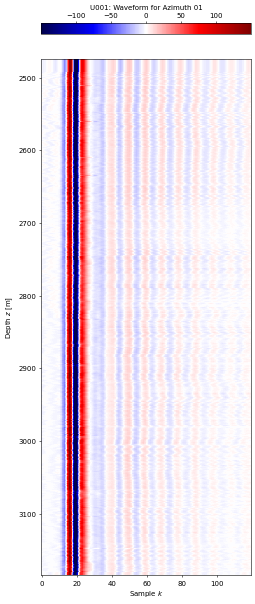

In [50]:
u001 = get_channel(frame60B, 'U001')

u001_max = np.max(np.abs(curves60B['U001']))
u001_lim = 0.5*u001_max

us_pltargs = {
    'cmap': 'seismic',
    'vmin': -u001_lim,
    'vmax': u001_lim
}

us_samples = np.arange(u001.dimension[0])

fig, ax = plt.subplots(figsize=(5, 12), constrained_layout=True)
im = paint_channel(ax, curves60B['U001'], curves60B[frame60B.index], us_samples, **us_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{u001.name}: {u001.long_name}')
ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('Sample $k$');

This channel shows ultrasonic pulse-echo waveforms similar to those shown in the literature. The strong pulse at the beginning is the reflection from the interface between the casing fluid and the casing, also known as the first-interface echo (FIE). After the FIE, we find a resonance corresponding to the pulse bouncing back and forth inside the casing. From the literature, we know that:

* The frequency of this resonance provides information on the casing thickness. The lower the frequency, the thicker the casing.
* The decay of the resonance provides information on the material behind the casing. The higher the impedance of that material, the faster the resonance decays.

The `U001` channel gives us the waveforms at every depth for one single azimuth. To have all the waveforms at every azimuth, we want to load all of the waveform channels and assemble them into one large three-dimensional numpy array `us_data(i,j,k)`, where the first dimension corresponds to depth, the second to azimuth, and the third to sample number.

In [51]:
# Create a numpy array to hold every waveform
nppw = f.object('PARAMETER', 'NPPW').values[0]
us_data = np.zeros((len(curves60B[frame60B.index]), nwpd, nppw))

def azim_to_name(j):
    """Return the name of the waveform channel corresponding to azimuth index j"""
    return f'U{j + 1:03}'

# Read all the waveform data into us_data
for j in range(nwpd):
    us_data[:, j, :] = curves60B[azim_to_name(j)]

As a test, let's plot the waveform data from every azimuth at the same depth:

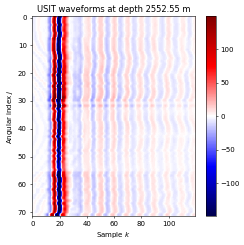

In [52]:
i_us = 4150

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(us_data[i_us, :, :], aspect='auto', **us_pltargs)
cbar = fig.colorbar(im, ax=ax)
ax.set_ylabel('Angular index $j$')
ax.set_xlabel('Sample $k$')
ax.set_title(f'USIT waveforms at depth {curves60B[frame60B.index][i_us]:.2f} m')
fig.set_tight_layout(True)

### Compensating for waveform gain

We can see that some of the waveforms are weaker overall than others, which may indicate that the waveforms are scaled differently before stored. Looking through the azimuthal image channels for a channel that might specify the scaling applied to each waveform, we find two likely candidates:

* `UPGA` ("USIC Programmable Gain Amplitude of Waves") and 
* `WAGN` ("Waveform Applied Gain") channels.

Both have units of dB. Let's see what they look like:

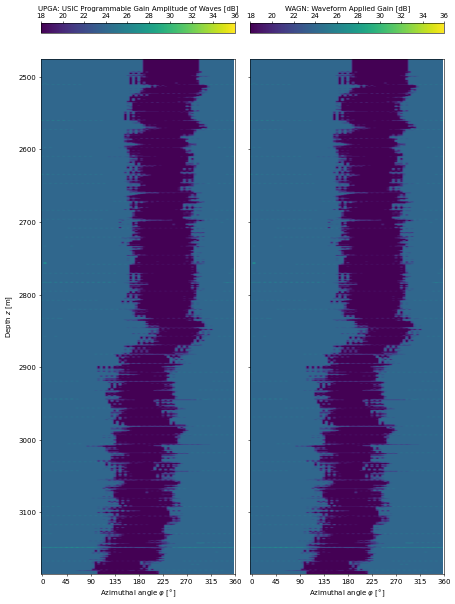

In [53]:
upga = get_channel(frame60B, 'UPGA')
wagn = get_channel(frame60B, 'WAGN')

fig, axes = plt.subplots(ncols=2, figsize=(9, 12), sharey=True, constrained_layout=True)

ax = axes[0]
im = paint_channel(ax, curves60B['UPGA'], curves60B[frame60B.index], ang)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{upga.name}: {upga.long_name} [{upga.units}]')
ax.set_ylabel('Depth $z$ [m]')

ax = axes[1]
im = paint_channel(ax, curves60B['WAGN'], curves60B[frame60B.index], ang)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wagn.name}: {wagn.long_name} [{wagn.units}]')

for ax in axes:
    ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')
    ax.set_xticks(np.linspace(0, 360, 9))

These two look pretty much identical, and show a band of lower gain through the middle, similar to the band of weaker waveforms in the middle of the waveform-against-azimuth image above. We may be able to use these to reequalise the amplitudes of the waveforms.

But first, let's check how similar the two channels are by looking at their maximum absolute difference:

In [54]:
gain_diff = curves60B['UPGA'] - curves60B['WAGN']
print('Maximum absolute difference between UPGA and WAGN:', np.max(np.abs(gain_diff)), upga.units)

Maximum absolute difference between UPGA and WAGN: 0.0 dB


So, the two channels are, in fact, identical in this file. Let's use `WAGN` in the following, as "Waveform Applied Gain" sounds exactly like what we are looking for. To reequalise the waveforms' amplitudes, we need to convert this decibel gain into a scaling factor $10^{-\mathtt{WAGN}/20}$ that we multiply every waveform with:

In [55]:
us_waveform_scaling = 10**(-curves60B['WAGN']/20)
us_data_reeq = us_data.copy() * us_waveform_scaling[:, :, np.newaxis]

Finally, let's verify that this has reequalised the waveforms by replotting the same waveform-against-angle image as above.

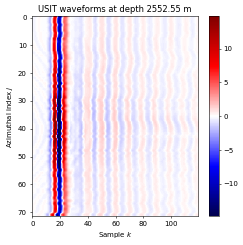

In [56]:
us_max = np.max(np.abs(us_data_reeq))
us_lim = 0.5*us_max

us_reeq_pltargs = {
    'cmap': 'seismic',
    'vmin': -us_lim,
    'vmax': us_lim
}

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(us_data_reeq[i_us, :, :], aspect='auto', **us_reeq_pltargs)
cbar = fig.colorbar(im, ax=ax)
ax.set_ylabel('Azimuthal index $j$')
ax.set_xlabel('Sample $k$')
ax.set_title(f'USIT waveforms at depth {curves60B[frame60B.index][i_us]:.2f} m')
fig.set_tight_layout(True)

Success! After correcting the waveform amplitudes with `WAGN`, the waveforms' amplitudes do not have the same sudden transitions any longer.

While there is no difference between the `WAGN` and `UPGA` channels in this file, or indeed most of the other integrity logs in the Volve dataset, the logs from well F-12 do show such a difference. In these logs, the `WAGN` channels give a better correction than the `UPGA` channels do.


### Finding the time axis of the ultrasonic waveforms

Even though we now have all of the ultrasonic waveform data in the DLIS file, we are in a similar situation as we were in for the sonic waveforms: We do not know what the time axis of each waveform is.

The `USFR` ("Ultrasonic Sampling Frequency") parameter seems like a promising first step, but its values throughout the DLIS files in the Volve Data Village dataset (500&nbsp;kHz, 666&nbsp;kHz, and even 0&nbsp;kHz) are much too low to be accurate when we know from the literature that the ultrasonic pulses can carry significant energy from 200–700&nbsp;kHz. For that reason, we'll have to discount this parameter.

Instead, we can look more closely at the three depth-by-azimuth channels with time units, namely `WFDL` ("Waveform Delay"), `TTBK` ("Transit Time"), and `UTIM` ("Time of Arrival of Waves").

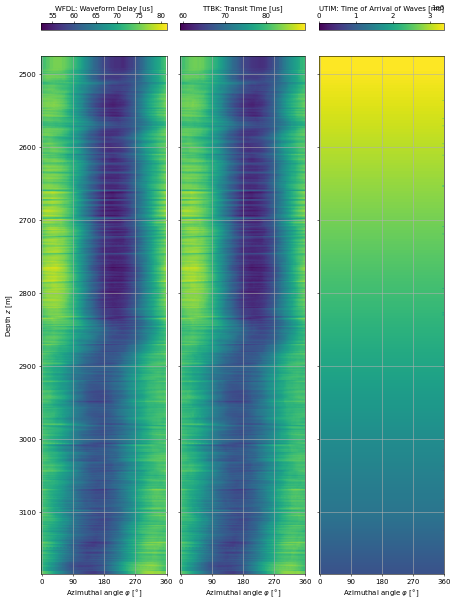

In [57]:
wfdl = get_channel(frame60B, 'WFDL')
ttbk = get_channel(frame60B, 'TTBK')
utim = get_channel(frame60B, 'UTIM')

fig, axes = plt.subplots(ncols=3, figsize=(9,12), sharey=True, constrained_layout=True)

ax = axes[0]
im = paint_channel(ax, curves60B['WFDL'], curves60B[frame60B.index], ang)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wfdl.name}: {wfdl.long_name} [{wfdl.units}]')
ax.set_ylabel('Depth $z$ [m]')

ax = axes[1]
im = paint_channel(ax, curves60B['TTBK'], curves60B[frame60B.index], ang)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{ttbk.name}: {ttbk.long_name} [{ttbk.units}]')

ax = axes[2]
im = paint_channel(ax, curves60B['UTIM'], curves60B[frame60B.index], ang)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{utim.name}: {utim.long_name} [{utim.units}]')

for ax in axes:
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.grid(True)
    ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')

First, let's look closer at `UTIM`. As it increases from a low value at the bottom of the well (where the logging tool starts) to a high value at the top of the well, it might represent the times, relative to some initial reference time, at which each waveform was measured. If that is the case, we can expect that the time between the first and last values of `UTIM` corresponds to other time measures in the file. While there is no time index channel in the file, we can at least find an average tool speed from the `CS` ("Cable speed") channel that we can compare with.

In [58]:
utim_bottom = np.min(curves60B['UTIM'][0,:]) / 1000   # Converted to from ms to s
utim_top = np.min(curves60B['UTIM'][-1,:]) / 1000     # Converted to from ms to s
print(f'UTIM at bottom:  {utim_bottom/60:.2f} min')
print(f'UTIM at top:     {utim_top/60:.2f} min')
utim_diff = (utim_top-utim_bottom)
print(f'UTIM difference: {utim_diff/60:.2f} min')
print()

cs_mean = np.mean(curves60B['CS']) / 3600   # Converted from m/h to m/s
print(f'Mean cable speed: {cs_mean*60:.2f} m/min')

depths = curves60B[index60B.name]
depth_range = max(depths) - min(depths)
print(f'Depth range: {depth_range:.2f} m')
cable_time = depth_range/cs_mean
print(f'Expected bottom-to-top time: {cable_time/60:.2f} min')
print()

print(f'UTIM-cable time difference: {utim_diff - cable_time} s')

UTIM at bottom:  14.10 min
UTIM at top:     56.35 min
UTIM difference: 42.25 min

Mean cable speed: 16.83 m/min
Depth range: 710.18 m
Expected bottom-to-top time: 42.20 min

UTIM-cable time difference: 3.008782484166204 s


The estimated time of the log tool moving from the bottom to the top of the well, as found from the mean cable speed, corresponds very well with the difference in `UTIM` values at the top and the bottom of the well. Thus, `UTIM` does seem to represent the time at which each waveform was measured.

We can look more closely at `UTIM` to see when the different measurements at each depth were made:

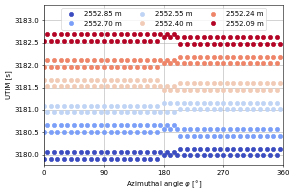

In [59]:
# Choose the depth indexes to plot at
n_depths = 6
i_min = 4148
i_max = i_min + n_depths

fig, ax = plt.subplots()

# Plot the UTIM values for each depth index i against azimuthal angle
colors = mpl.cm.coolwarm(np.linspace(0, 1, n_depths))
for j in range(n_depths):
    ax.plot(ang, curves60B['UTIM'][i_min+j, :]/1000, 'o', color=colors[j])
ax.set_ylabel('UTIM [s]')
ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')
ax.set_xlim(0, 360)
ax.set_xticks((0, 90, 180, 270, 360))
ax.grid(True)

# Create space at the top for the legend
ylim = list(ax.get_ylim())
ylim[1] += 0.5
ax.set_ylim(ylim)
legend = [f'{curves60B[frame60B.index][i]:.2f} m' for i in range(i_min, i_max)]
ax.legend(legend, loc='upper center', ncol=3)

fig.set_tight_layout(True)

This indicates that the tool measures at every second azimuth during one rotation, and fills in the remaining azimuthal measurements during a later rotation.

Next up are `WFDL` and `TTBK`. The latter is called "Transit Time", which we may assume corresponds to the "Travel time" defined in the [USIT article by Hayman et al. (1991)](https://www.onepetro.org/conference-paper/SPWLA-1991-KK) as the time of arrival of an estimate of the FIE envelope maximum. (While the Hayman et al. article describes a fast approximate method to find the envelope maximum, the [USIT patent by Wright (1993)](https://patents.google.com/patent/US5216638/en) describes a more accurate approach that we will follow in the following.) Thus, it represents the time the pulse takes from the transducer to the casing and back.

This implies that the differences between high and low `TTBK` values at the same depth come from the tool being eccentered; the travel time is shortest when the transducer is pointing in the direction of eccentering, and longest when it is pointing against the direction of eccentering. This also implies that the waveforms stored in the `U001`, `U002`, `...` channels have been shifted to align their peaks.

As the two channels do seem to have the same overall shape, but with an offset, then maybe `WFDL` represents the time of the first sample? Let's plot histograms of the two channels and their difference to have a closer look:

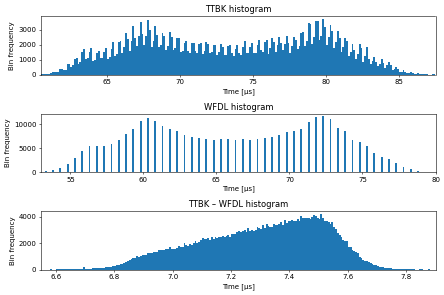

In [60]:
time_diff = curves60B['TTBK'] - curves60B['WFDL']

fig, axes = plt.subplots(figsize=(9,6), nrows=3)

ax = axes[0]
xlim = (60.5, 87.5)
ax.hist(curves60B['TTBK'].flatten(), bins=np.linspace(xlim[0], xlim[1], 217))
ax.set_xlim(xlim)
ax.set_title('TTBK histogram')

ax = axes[1]
xlim = (53, 80)
ax.hist(curves60B['WFDL'].flatten(), bins=np.linspace(xlim[0], xlim[1], 217))
ax.set_xlim(xlim)
ax.set_title('WFDL histogram')

ax = axes[2]
xlim = (6.55, 7.9)
hist = ax.hist(time_diff.flatten(), bins=np.linspace(xlim[0], xlim[1], 217))
ax.set_xlim(xlim)
ax.set_title('TTBK – WFDL histogram')

for ax in axes:
    ax.set_xlabel('Time [µs]')
    ax.set_ylabel('Bin frequency')

fig.set_tight_layout(True)

`TTBK` and `WFDL` do indeed have the same overall shape, and their difference is almost always between 6.7&nbsp;µs and 7.7&nbsp;µs. But the most interesting result here is the `WFDL` histogram, which indicates that the values of `WFDL` are quantised, with a constant step separating them.

If the waveforms are all 120 samples and aligned to each other, this implies that a longer waveform was originally recorded and that the waveforms present in the files are shorter extracts of these original waveforms, selected so that the peaks of all waveforms are aligned. If that is the case, the step between the `WFDL` values should represent the sampling period of the waveforms. Let's find out what that step is by looking at the differences between adjacent values of `WFDL`:

In [61]:
from collections import Counter

wfdl_flat = curves60B['WFDL'].flatten()
diff_counter = Counter(np.round( np.abs(wfdl_flat[1:] - wfdl_flat[0:-1]), decimals=4))

print(diff_counter)

Counter({0.5: 154695, 0.0: 89262, 1.0: 73334, 1.5: 14725, 2.0: 1997, 2.5: 736, 3.0: 432, 3.5: 221, 4.0: 96, 4.5: 42, 5.0: 14, 6.0: 9, 6.5: 9, 5.5: 8, 7.0: 7, 7.5: 4})


Thus, we have found that the step is 0.5&nbsp;µs, which seems to be the waveform sampling period. If so, the sampling rate of the ultrasonic waveforms is 2&nbsp;MHz.

We thus assume that `WFDL` specifies the time of the first waveform sample, `TTBK` the arrival time of the pulse, and that the waveforms are sampled at 2&nbsp;MHz. We can test all of this to check that it fits, by comparing the difference `TTBK` – `WFDL` with the time between the first sample and the pulse arrival. We find the arrival of the pulse through a quadratic fit around the peak of its envelope. The envelope is [found as the magnitude of the analytic signal](https://en.wikipedia.org/wiki/Analytic_signal#Envelope_and_instantaneous_phase) found through the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform).

In [62]:
# Calculate TTBK - WFDL
ttbk_wfdl_diff = curves60B['TTBK'] - curves60B['WFDL']

# Compute the envelope of every waveform in the file
us_env = np.abs(signal.hilbert(us_data_reeq, axis=2))

# Compute the relative time (time since the first sample) of every sample
us_t_rel = 0.5 * np.arange(120)

We can first look at a single waveform and its envelope, and the peak found from the envelope

TTBK - WFDL for waveform: 7.48 us
Envelope peaks at 9.42 µs after first sample


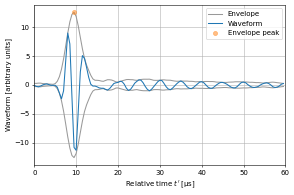

In [63]:
i_us = 4150    # Depth index of waveform to look at
j_us = 0      # Azimuthal index of waveform to look at

def find_peak(envelope, t_rel):
    """Find the time and amplitude of an envelope peak accurately using a quadratic polynomial fit"""
    i_max = np.argmax(envelope)
    i_range = i_max + np.array([-1, 0, 1]) 
    fit = np.polyfit(t_rel[i_range], envelope[i_range], 2)
    t_max = - fit[1] / (2 * fit[0])
    max_peak = np.polyval(fit, t_max)
    return t_max, max_peak

t_peak, max_peak = find_peak(us_env[i_us, j_us, :], us_t_rel)
print(f'TTBK - WFDL for waveform: {ttbk_wfdl_diff[i_us, j_us]:.2f} us')
print(f'Envelope peaks at {t_peak:.2f} µs after first sample')

fig, ax = plt.subplots()
ax.plot(us_t_rel, us_env[i_us, j_us, :], color='0.6', label='Envelope')
ax.plot(us_t_rel, -us_env[i_us, j_us, :], color='0.6')
ax.plot(us_t_rel, us_data_reeq[i_us, j_us, :], label='Waveform')
ax.plot(t_peak, max_peak, 'o', alpha=0.5, label='Envelope peak')
ax.set_ylabel('Waveform [arbitrary units]')
ax.set_xlabel("Relative time $t'$ [µs]")
ax.set_xlim(0, 60)
ax.legend()
ax.grid(True)
fig.set_tight_layout(True)

This was around 2&nbsp;µs off from what we expected. What do we find if we investigate the statistics of this difference for every waveform?

In [64]:
t_peaks = np.zeros(ttbk_wfdl_diff.shape)

for i in range(t_peaks.shape[0]):
    for j in range(t_peaks.shape[1]):
        t_peaks[i, j], _ = find_peak(us_env[i, j, :], us_t_rel)

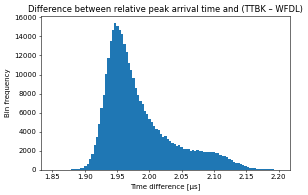

In [65]:
fig, ax = plt.subplots()
ax.hist((t_peaks - ttbk_wfdl_diff).flatten(), bins=np.linspace(1.85,2.2,100))
ax.set_xlabel('Time difference [µs]')
ax.set_ylabel('Bin frequency')
ax.set_title('Difference between relative peak arrival time and (TTBK – WFDL)')
fig.set_tight_layout(True)

Unless our assumptions about the meanings of the `WFDL` and/or `TTBK` channels are incorrect, this means that `WFDL` and `TTBK` use different reference times. In that case, the values from one would need to be offset to be directly comparable to the values form the other.

Another look at the list of USIT parameters shows us that there is a parameter called `USTO` (‘USIT Time Offset’), with the value of –2&nbsp;µs. If we assume that `WFDL` must first be corrected as `WFDL`+`USTO`, the aforementioned difference becomes close to zero:

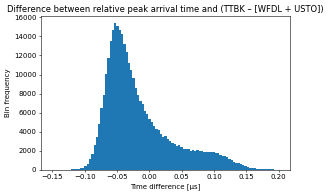

In [66]:
# Calculate TTBK - (WFDL + USTO)
usto = f.object('PARAMETER', 'USTO').values[0]
ttbk_wfdl_diff2 = curves60B['TTBK'] - (curves60B['WFDL'] + usto)

fig, ax = plt.subplots()
ax.hist((t_peaks - ttbk_wfdl_diff2).flatten(), bins=np.linspace(-0.15,0.2,100))
ax.set_xlabel('Time difference [µs]')
ax.set_ylabel('Bin frequency')
ax.set_title('Difference between relative peak arrival time and (TTBK – [WFDL + USTO])')
fig.set_tight_layout(True)

The remaining differences that we now find is much smaller than the sampling period of 0.5&nbsp;µs. While we don't know exactly where they come from, they might simply stem from the USIT processing having a slightly different method to estimate the time of the envelope peak than the method we have used here.

We can then find the time axis of every waveform by using `WFDL`+`USTO` as the time of the first sample. We'll put it in an array with the same shape as the waveforms, i.e., depth by angle by sample.

In [67]:
us_t0 = curves60B['WFDL'] + usto
us_t = us_t0[:, :, np.newaxis] + us_t_rel[np.newaxis, np.newaxis, :]

Now we have a timestamp for every waveform sample. While the waveforms in the `U001`, `U002`, `...` channels were stored aligned to each other, we can use this time information to plot the waveforms with the same shift that they were originally recorded with. As an example, we can plot every waveform from the same depth into a polar plot.

/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_37145/155844224.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  return ax.pcolormesh(np.radians(ang_mesh), times, data, vmin=-vmax, vmax=vmax, cmap='seismic')
/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_37145/155844224.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  return ax.pcolormesh(np.radians(ang_mesh), times, data, vmin=vmax-50, vmax=vmax, cmap='CMRmap')


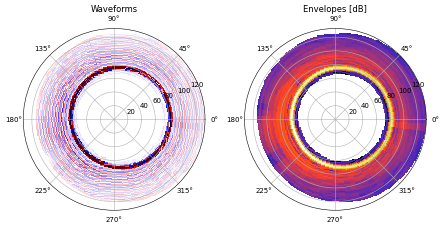

In [68]:
def waveform_cross_section(ax, i=0, envelope=False):
    """Plot waveform data (or its logaritmic envelope) as a polar plot at a given depth index"""
    
    # Get the base data to plot
    times = us_t[i,:,:]
    if envelope:
        data = 20*np.log10(us_env[i,:,:])
    else:
        data = us_data_reeq[i,:,:]
    ang_mesh = np.repeat(ang[:, np.newaxis], data.shape[1], axis=1)
    n_ang = data.shape[0]
    
    # Make some transformations of the data to ensure that the pcolormesh plot function plots each
    # sample as an isosceles trapezoid centred at the sample's angle and time.
    
    # Repeat every element in the base data twice along the angle axis
    ang_mesh = np.repeat(ang_mesh, 2, axis=0)
    times = np.repeat(times, 2, axis=0)
    data = np.repeat(data, 2, axis=0)
    data = data[:-1, :-1]   # Used for trapezoid centres; need one fewer value than for trapezoid corners
    
    # Shift the coordinates so that each trapezoid is centered at the sample's angle and time
    ang_mesh = ang_mesh - (360 / n_ang) / 2
    times = times - 0.25
    
    # Roll the azimuthal mesh
    ang_mesh = np.roll(ang_mesh, shift=-1, axis=0)
    ang_mesh[-1, :] += 360   # Ensure that trapezoid corner coordinates are strictly increasing
    
    if envelope:
        vmax = np.max(data)
        return ax.pcolormesh(np.radians(ang_mesh), times, data, vmin=vmax-50, vmax=vmax, cmap='CMRmap')
    else:
        vmax = np.max(np.abs(data)) / 5
        return ax.pcolormesh(np.radians(ang_mesh), times, data, vmin=-vmax, vmax=vmax, cmap='seismic')

        
i_us = 4150

fig, axes = plt.subplots(ncols=2, subplot_kw=dict(polar=True), figsize=(9,5))  

ax = axes[0]
pc = waveform_cross_section(ax, i_us, envelope=False)
ax.set_title('Waveforms')

ax = axes[1]
waveform_cross_section(ax, i_us, envelope=True)
ax.set_title('Envelopes [dB]')

for ax in axes:
    ax.grid(True)

fig.set_tight_layout(True)

We can see that the FIE is received at different times at different angles. This reflects the eccentering of the USIT; where the tool is closer to the wall, the FIE will be received earlier, and where the tool is further away, the FIE will be received later.

**Waveform summary:** The waveforms recorded by the USIT are organised into channels `U001`, `U002`, `...` according to the azimuthal angle at which they were recorded. Different waveforms may have had different gains to them, and these gains can be compensated for using the `WAGN` channel. The recorded waveforms are stored in such a way that the first interface echoes (FIEs) are aligned with each other. The time axis of each waveform can be found through two steps:

* The time of the first sample for the waveform at $i, j$ is `WFDL(i,j) + USTO`.
* The waveforms' sampling period of 0.5&nbsp;µs can be used to find the time of the remaining samples.

## Simple reprocessing of the waveforms

Now that we understand the ultrasonic waveforms better, we can look at a simple example of what we can do with them. We can investigate a simple way to draw information about the well status from them and compare with the reference information present in the log file.

First of all, let's look at a waveform and its envelope.

In [69]:
us_env_dB = 20*np.log10(us_env)

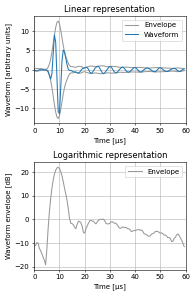

In [70]:
fig, axes = plt.subplots(nrows=2, figsize=(4,6))

ax = axes[0]
ax.plot(us_t_rel, us_env[i_us, j_us, :], color='0.6', label='Envelope')
ax.plot(us_t_rel, -us_env[i_us, j_us, :], color='0.6')
ax.plot(us_t_rel, us_data_reeq[i_us, j_us, :], label='Waveform')
ax.set_xlim(0, 60)
ax.legend()
ax.grid(True)
ax.set_ylabel('Waveform [arbitrary units]')
ax.set_xlabel('Time [µs]')
ax.set_title('Linear representation')

ax = axes[1]
ax.plot(us_t_rel, us_env_dB[i_us, j_us, :], color='0.6', label='Envelope')
ax.set_xlim(0, 60)
ax.legend()
ax.grid(True)
ax.set_ylabel('Waveform envelope [dB]')
ax.set_xlabel('Time [µs]')
ax.set_title('Logarithmic representation')

fig.set_tight_layout(True)

The waveform contains a strong initial reflection from the fluid-casing interface, followed by a decaying resonance of the pulse component that was transmitted into the casing. [From the literature](https://www.onepetro.org/conference-paper/SPWLA-1991-KK), we know that this decay should be at least approximately exponential, and that the decay is faster for higher-impedance materials behind the casing. And if the decay is exponential, it should be approximately linear on a logarithmic plot like the one shown here.

The impedance behind the casing, which is available in the `AIBK` channel, has been found through the aforementioned [T<sup>3</sup> algorithm](https://www.onepetro.org/conference-paper/SPWLA-1991-KK), which is relatively complex. We will not try to reproduce it here; instead, we will try to get similar information through a linear fit of the logarithmic envelope, which has also been used by [Sirevaag et al.](https://www.onepetro.org/conference-paper/SPWLA-2018-I) to investigate the impedance behind the casing. This gives us a decay rate $L_1$ in dB/µs, which we can then compare against the impedance in the `AIBK` channel.

We first show this for a single waveform envelope as an example:

L_1 value: 0.158 dB/µs


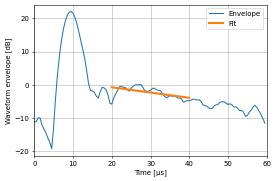

In [71]:
i_us = 4150

def fit_decay(env_dB, env_t, fit_slice):
    """Find a linear fit over the fit_slice indices in env_dB and env_t and return it"""
    return np.polyfit(env_t[fit_slice], env_dB[fit_slice], 1)

# Specify the range of the fit
t_fit = [20, 40]                                   # Time range to carry out the fit in
i_fit = [np.argmin(np.abs(us_t_rel - t_fit[0])),   # First sample index of the range
         np.argmin(np.abs(us_t_rel - t_fit[1]))]   # Last sample index of the range
fit_slice = slice(i_fit[0], i_fit[1] + 1)          # The range expressed as a slice object

# Get the linear fit and evaluate it at the edges of the time range
fit = fit_decay(us_env_dB[i_us, j_us, :], us_t_rel, fit_slice)
val = np.polyval(fit, t_fit)

# Plot the envelope and the fit
fig, ax = plt.subplots()
ax.plot(us_t_rel, us_env_dB[i_us, j_us, :], label='Envelope')
ax.plot(t_fit, val, linewidth=3, label='Fit')
ax.set_xlim(0, 60)
ax.legend()
ax.grid(True)
ax.set_ylabel('Waveform envelope [dB]')
ax.set_xlabel('Time [µs]')

print(f'L_1 value: {-fit[0]:.3f} dB/µs')

We then find the decay rate $L_1$ for every waveform in the file:

In [72]:
us_L1 = np.zeros(curves60B['AIBK'].shape)
for i in range(us_L1.shape[0]):
    for j in range(us_L1.shape[1]):
        us_L1[i, j] = -fit_decay(us_env_dB[i, j, :], us_t_rel, fit_slice)[0]

We can then plot $L_1$ together with `AIBK` to compare them:

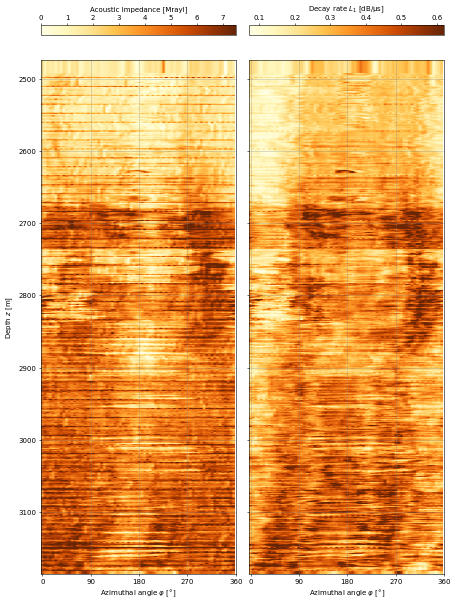

In [73]:
fig, axes = plt.subplots(figsize=(9,12), ncols=2, sharey=True, constrained_layout=True)

ax = axes[0]
min_quantile = np.mean(curves60B['AIBK'] <= 0)     # The quantile at which we find the value 0
max_quantile = np.mean(curves60B['AIBK'] <= 7.5)   # The quantile at which we find the value 7.5
im = paint_channel(ax, curves60B['AIBK'], curves60B[frame60B.index], ang, cmap='YlOrBr', vmin=0, vmax=7.5)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{aibk.long_name} [{aibk.units}]')
ax.set_ylabel('Depth $z$ [m]')

ax = axes[1]
vmin = np.quantile(us_L1, min_quantile)   # The value we find at quantile min_quantile in us_L1
vmax = np.quantile(us_L1, max_quantile)   # The value we find at quantile max_quantile in us_L1
im = paint_channel(ax, us_L1, curves60B[frame60B.index], ang, cmap='YlOrBr', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'Decay rate $L_1$ [dB/µs]')

for ax in axes:
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.grid(True, color='0.5', alpha=0.5)
    ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')

Comparing the two, we see the same overall patterns, especially near the top of the log. But how well correlated are their numerical values with each other? To look into that, we can calculate some correlation measures and plot a 2D histogram showing the joint distribution of the $L_1$ and impedance values:

In [74]:
import scipy.stats as stats

x = curves60B['AIBK'].flatten()
y = us_L1.flatten()

print(f'Pearson correlation:  {stats.pearsonr(x, y)[0]:.3f}')
print(f'Spearman correlation: {stats.spearmanr(x, y)[0]:.3f}')

Pearson correlation:  0.457
Spearman correlation: 0.634


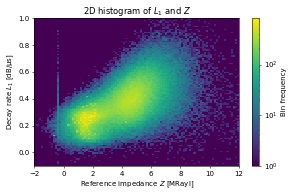

In [75]:
# Get a colormap that ensures that histogram bins with zero occurrences still have a colour
cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_bad(cmap.colors[0])

# Plot the 2D histogram
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, norm=mpl.colors.LogNorm(), cmap=cmap,
                 bins=[np.linspace(-2, 12, 100), np.linspace(-0.1, 1, 100)]);
cbar = fig.colorbar(hist[3], ax=ax)
cbar.set_label('Bin frequency')
ax.set_title('2D histogram of $L_1$ and $Z$')
ax.set_xlabel('Reference impedance $Z$ [MRayl]')
ax.set_ylabel('Decay rate $L_1$ [dB/µs]')

fig.set_tight_layout(True)

The correlation metrics and the histogram all show that there is a clear positive correlation between $L_1$ and the reference impedance, but it's far from a one-to-one-relationship between the two.

**Reprocessing summary:** While this is just a simple example of what we can do with the ultrasonic waveforms, it does show that the data present in these files lets us try out various processing algorithms on real-world data. One challenge with this approach is that we do not have access to a ground truth that we can use to objectively evaluate the quality of processing methods. All we have is the measured waveforms and one processing method's estimates of what the waveforms imply.